# Fraud Detection in Electricity and Gas Consumption Project

## References

https://www.kaggle.com/code/imgremlin/4th-place-in-fraud-detection-from-zindi/notebook

Feature engineering ideas were taken from this article. A limitation in this article is that it did not consider the issue of imbalanced data, causing model to have significant bias towards the negative class. Here, we overcame it through oversampling and undersampling methods such as SMOTE and EditedNearestNeighbours. The resulting models have less bias.

https://cs229.stanford.edu/proj2018/report/261.pdf

Some ideas were inspired by this research paper. In our project we explore other algorithms besides Linear SVM/SVM.

# Exploratory Data Analysis

In [2]:
# Load required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Configuration for QOL improvements
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 5)
plt.ion() # Enable interactive mode

In [3]:
# load the dataset
client = pd.read_csv('client.csv')
invoice = pd.read_csv('invoice.csv')

# drop rows with missing data
client.dropna(inplace=True)
invoice.dropna(inplace=True)

# get intersecting client ids
client_ids = pd.merge(client, invoice, on='id', how='inner')['id'].unique()
# filter dataframes
client = client[client['id'].isin(client_ids)]
invoice = invoice[invoice['id'].isin(client_ids)]
print(client.shape)
print(invoice.shape)

(31603, 6)
(1048575, 16)


## Client Visualizations

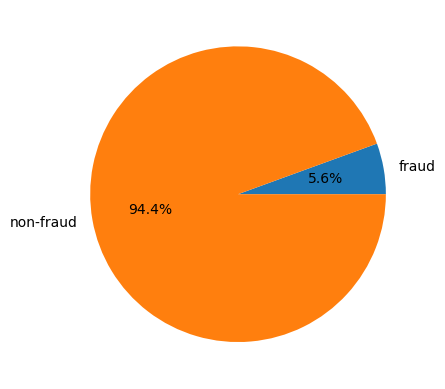

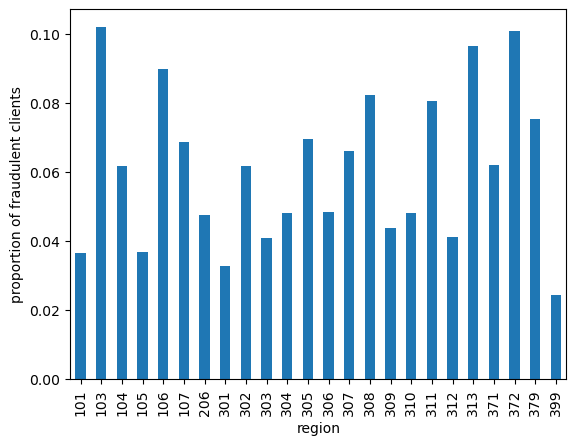

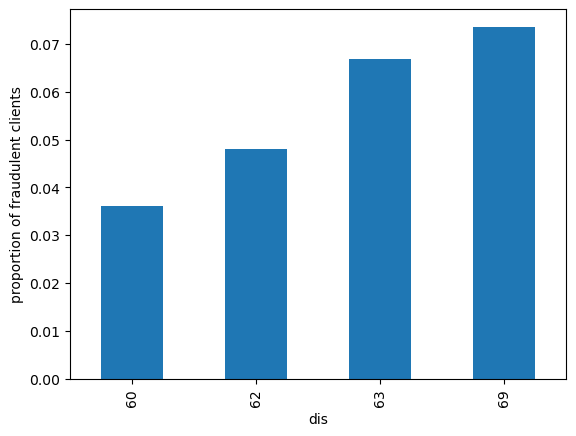

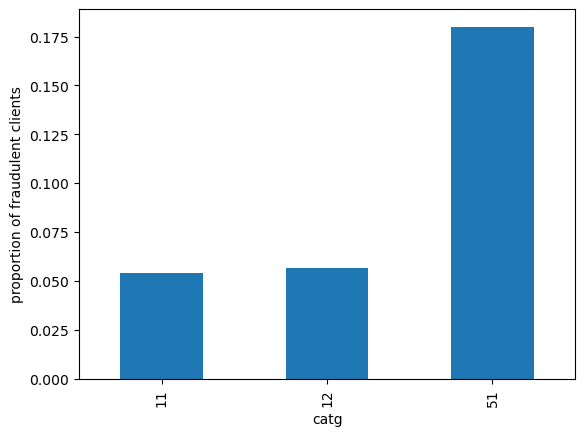

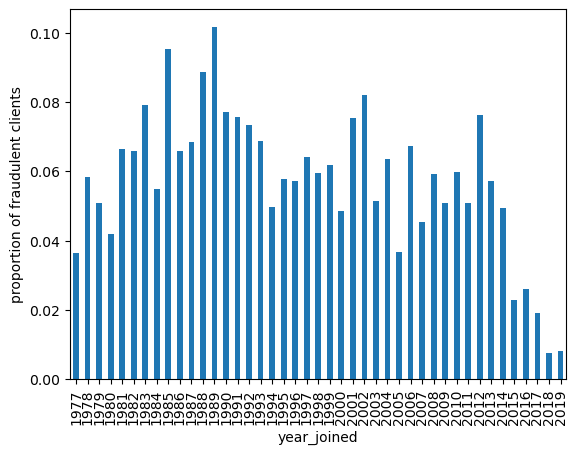

In [5]:
# compare proportion of target variable
fraud_prop = np.count_nonzero(client['target'] == 1) / len(client)
plt.pie([fraud_prop, 1-fraud_prop], labels=['fraud','non-fraud'], autopct='%1.1f%%')
plt.show()
# piechart shows highly imbalanced data

# visualize client data with matplotlib
# get separate dataframes for fraudulent and non-fraudulent clients
fraudulent = client[client['target'] == 1]
non_fraudulent = client[client['target'] == 0]

for col in ['region', 'dis', 'catg']:
    # see if any column has relationship with frauds
    f = fraudulent.groupby(col).size()
    nf = non_fraudulent.groupby(col).size()
    df = (f / (f + nf))
    df.plot(kind='bar', ylabel='proportion of fraudulent clients')
    plt.show()

# see if year joined has relationship with frauds
df = client[:]
df['year_joined'] = pd.to_datetime(df['date'], dayfirst=True).dt.year
fraudulent = df[df['target'] == 1]
non_fraudulent = df[df['target'] == 0]
f = fraudulent.groupby('year_joined').size()
nf = non_fraudulent.groupby('year_joined').size()
df = (f / (f + nf))
df.plot(kind='bar', ylabel='proportion of fraudulent clients')
plt.show()

### Client Observations
- Different regions have different proportions of fraudulent clients; region 103 has the highest and region 399 has the lowest
- Different districts have different proportions of fraudulent clients; district 69 has the highest and district 60 has the lowest
- Category 51 has highest proportion of fraudulent clients by far
- Clients that joined in 1989 have the highest proportion of fraud, and 2018 the lowest

## Invoice Visualization

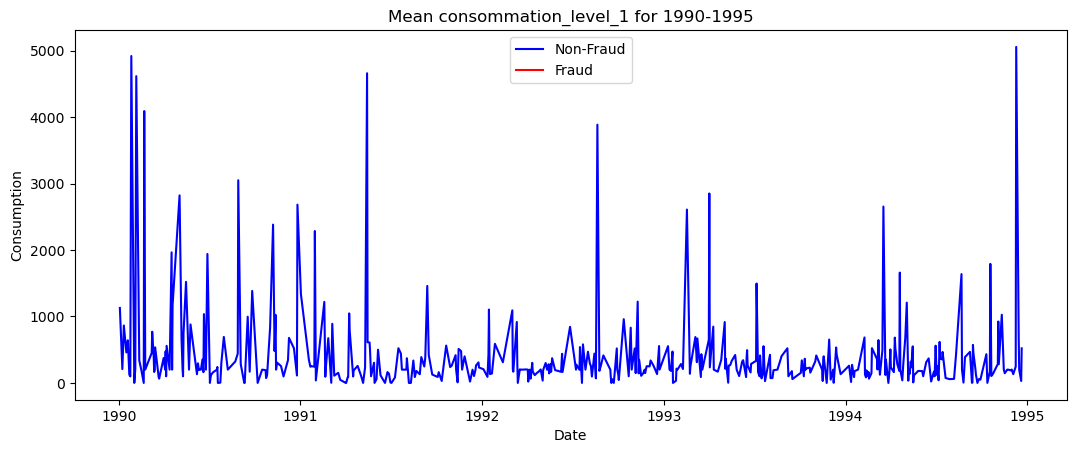

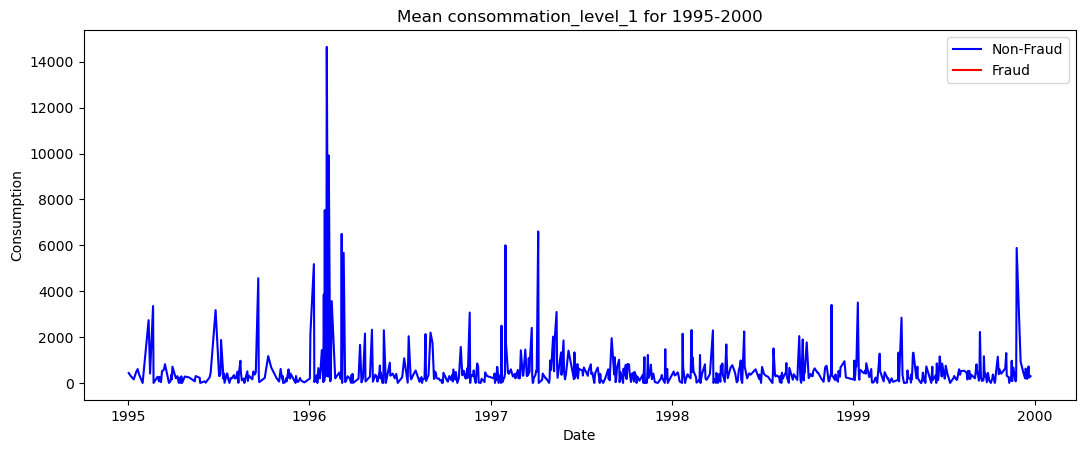

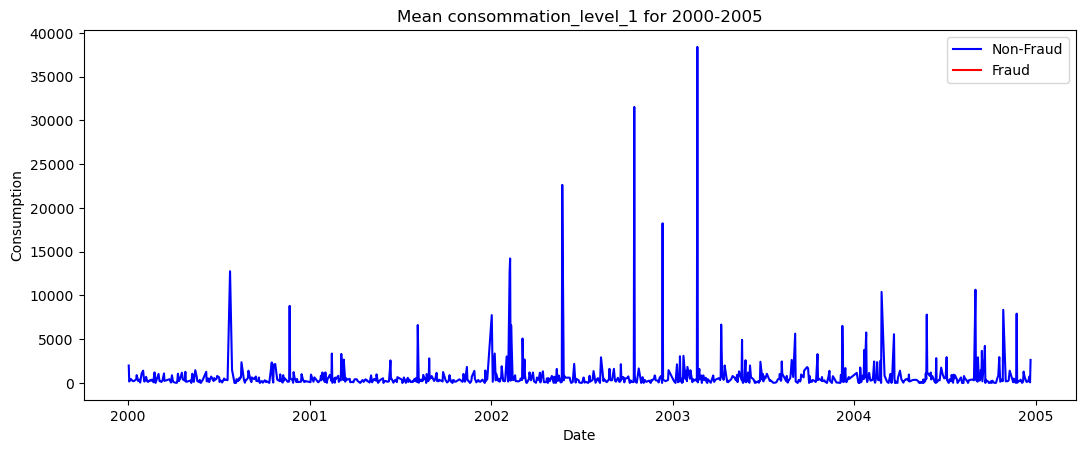

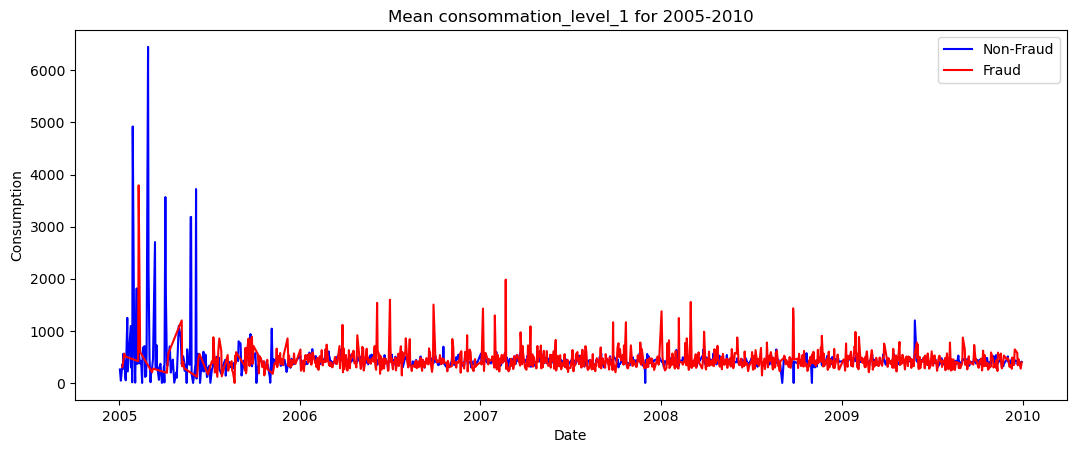

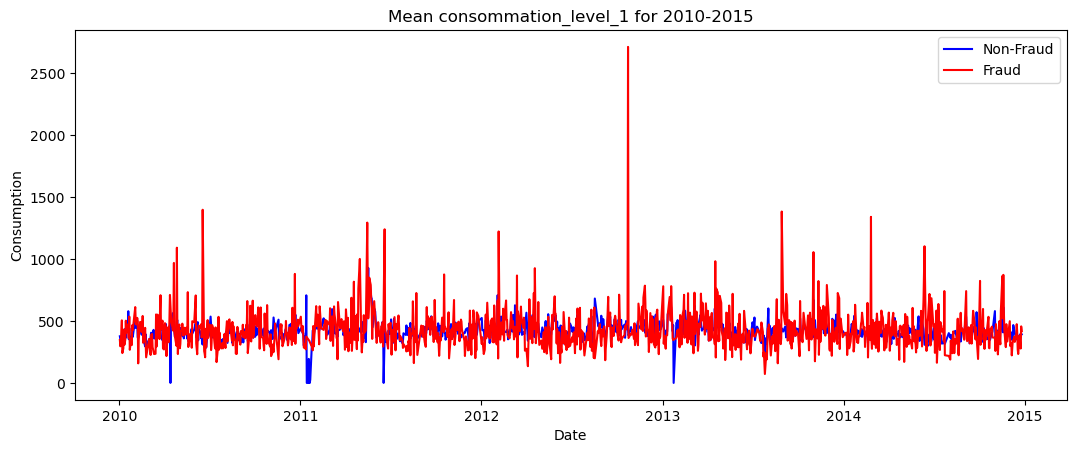

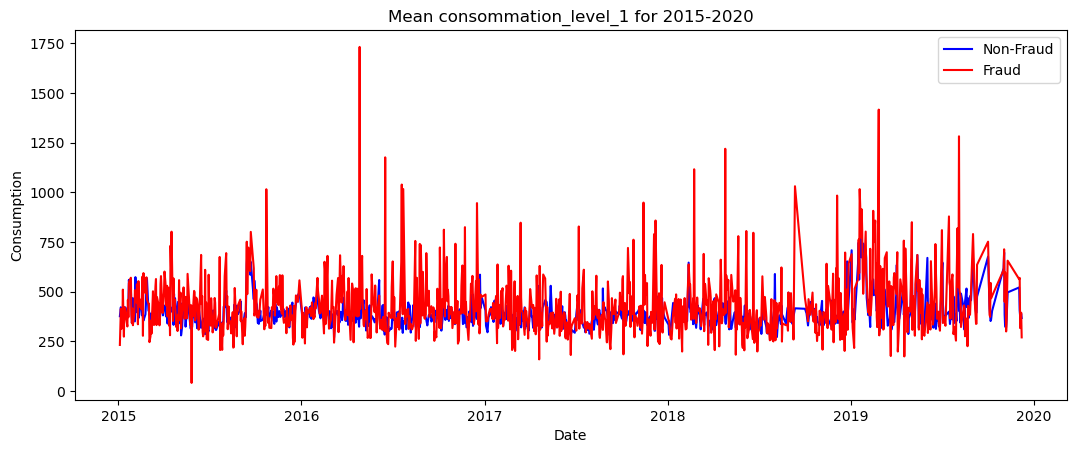

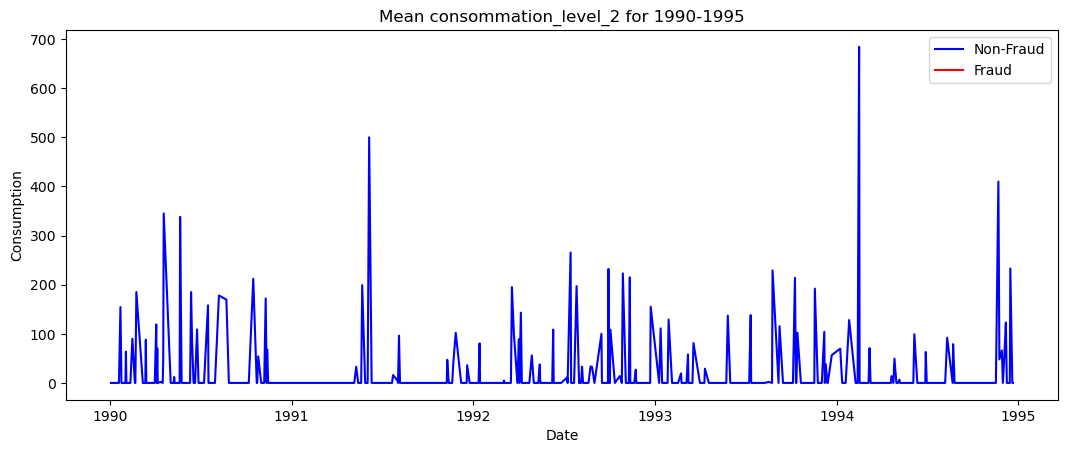

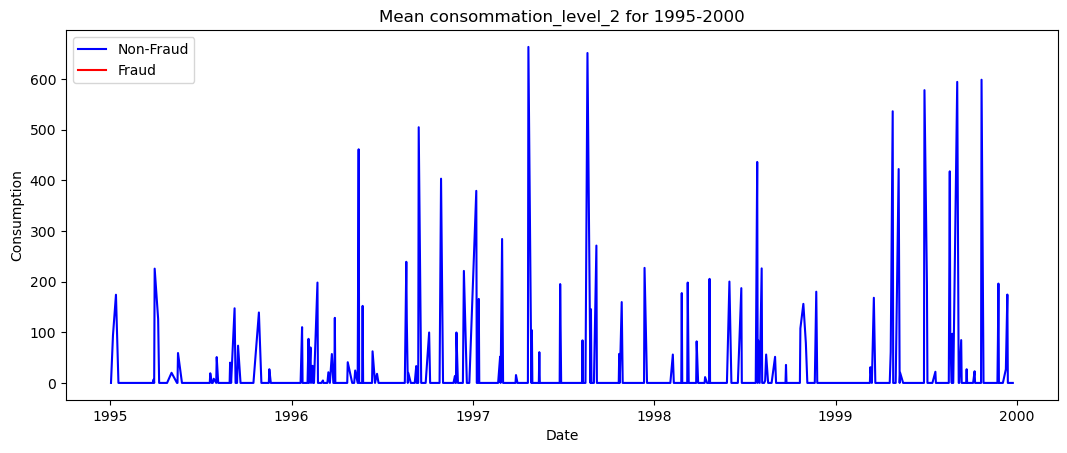

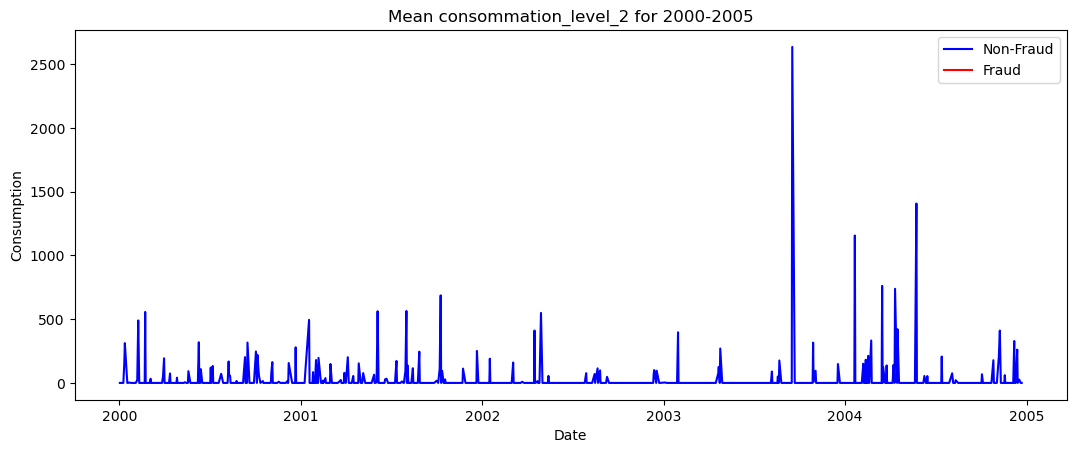

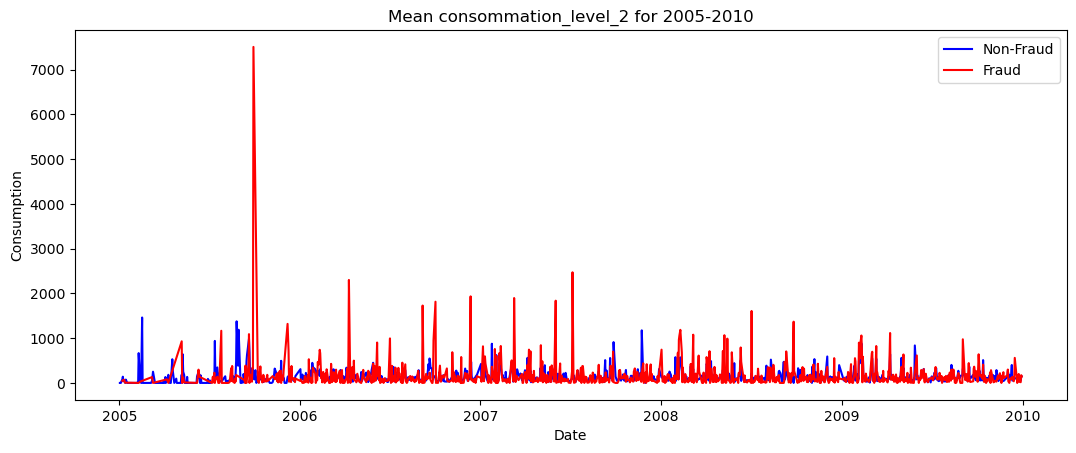

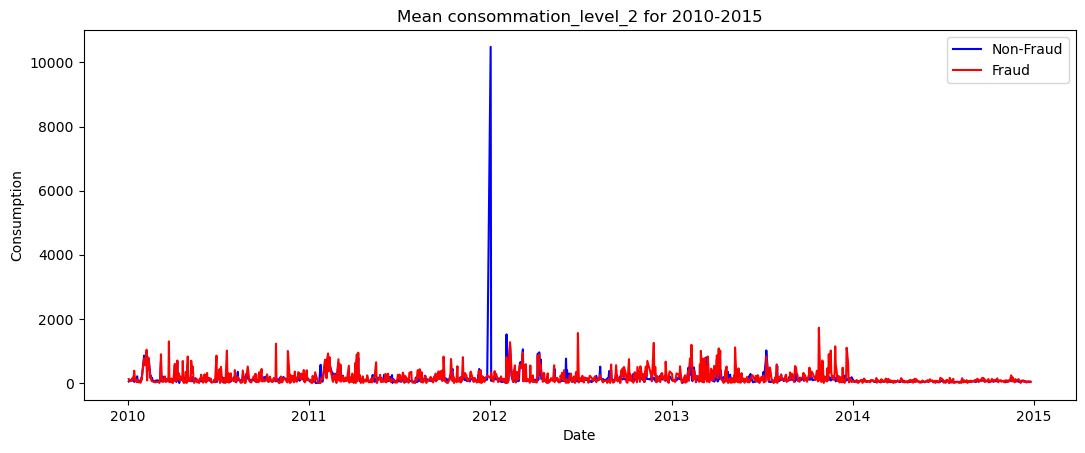

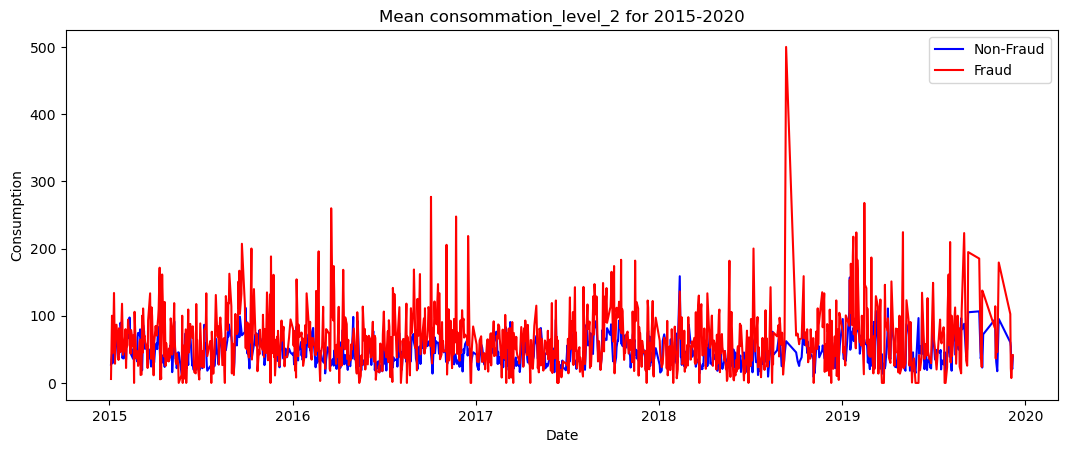

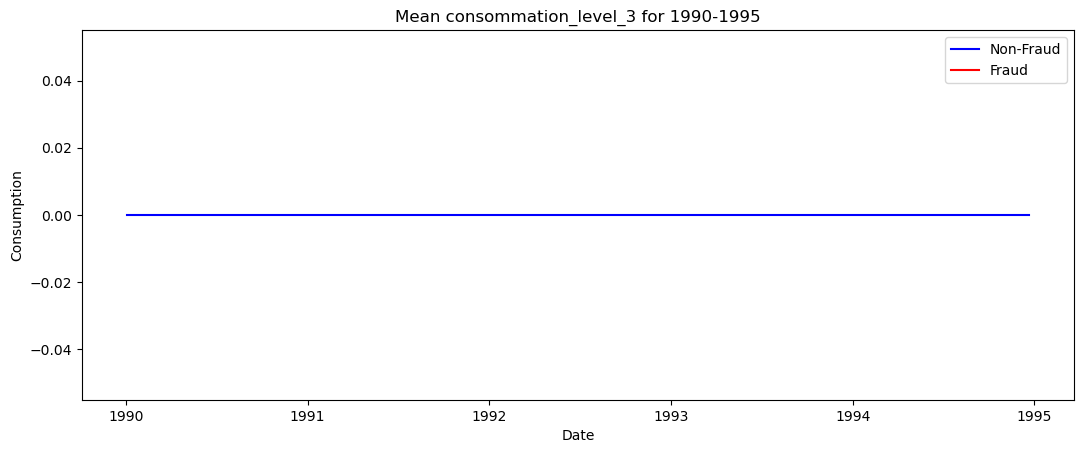

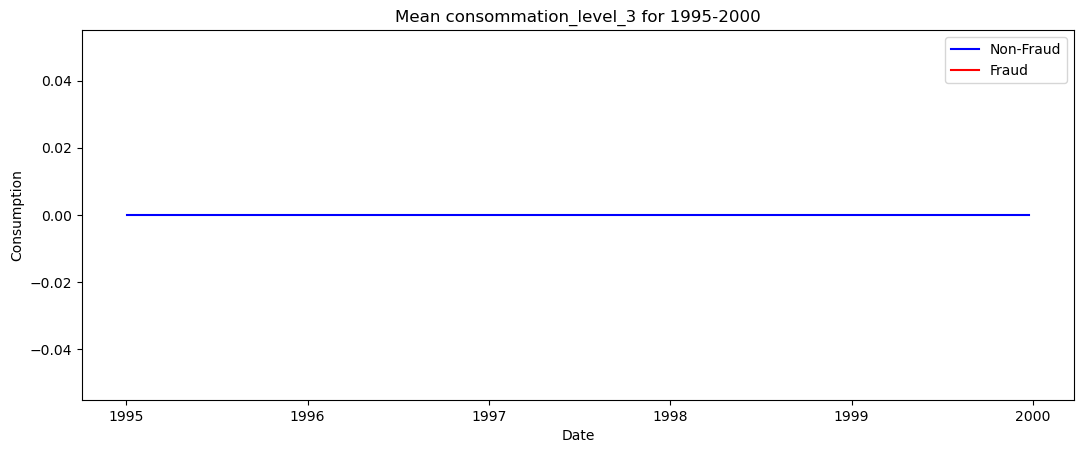

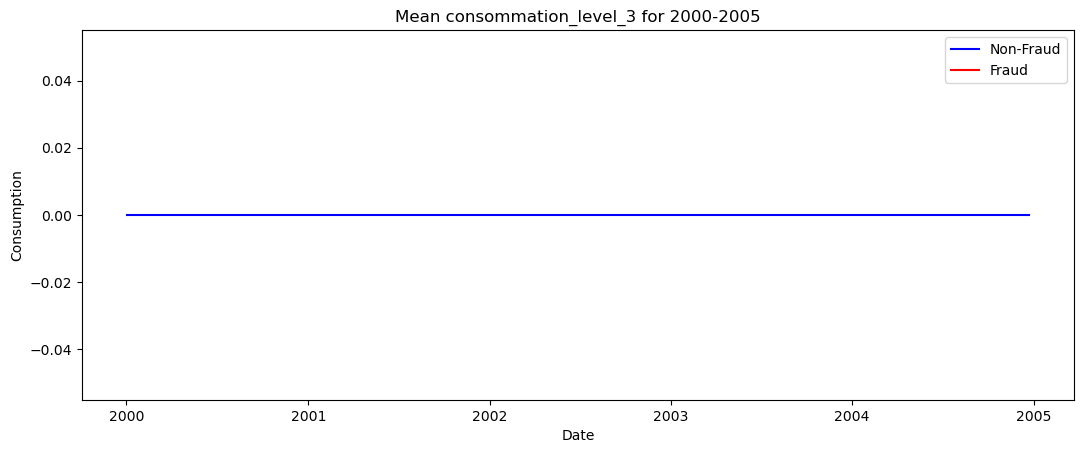

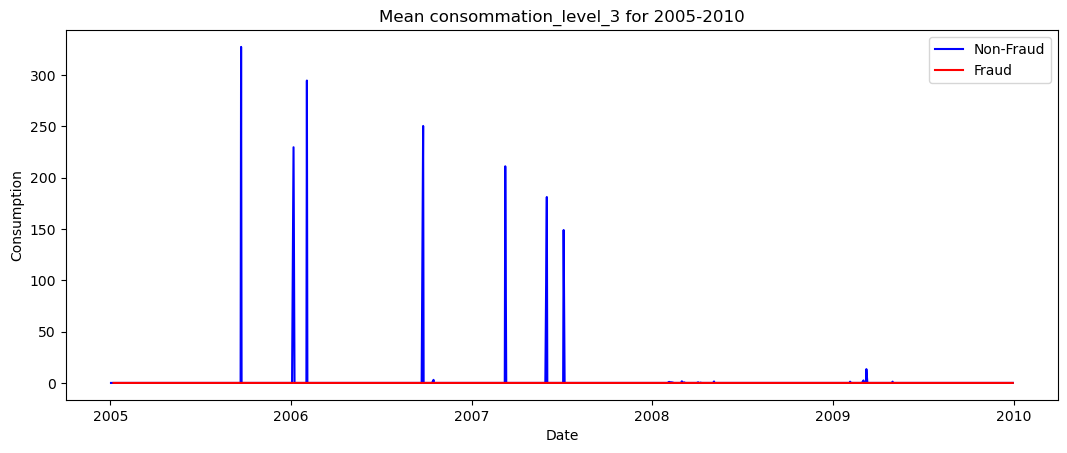

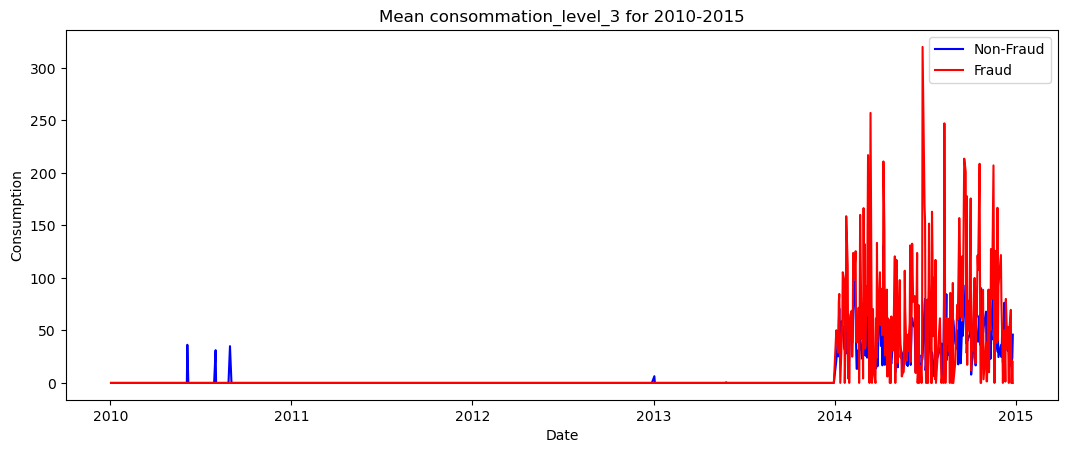

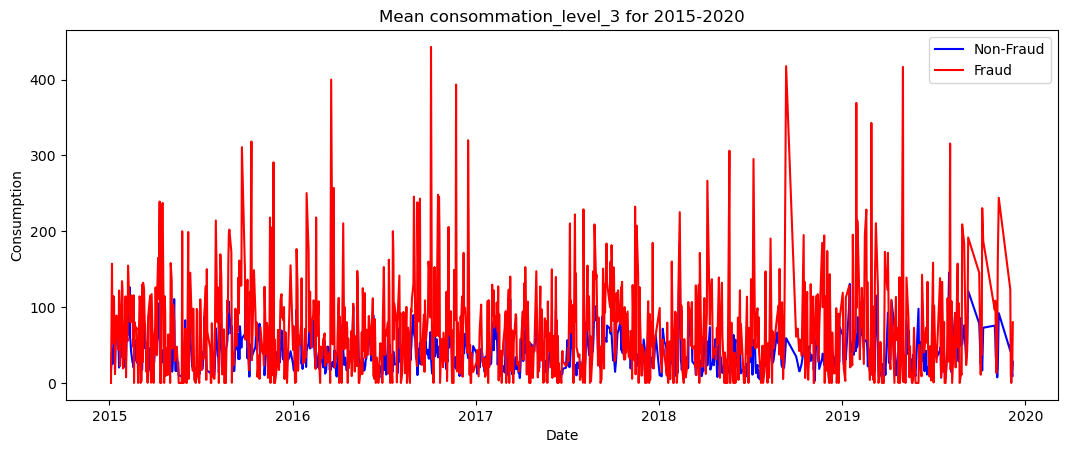

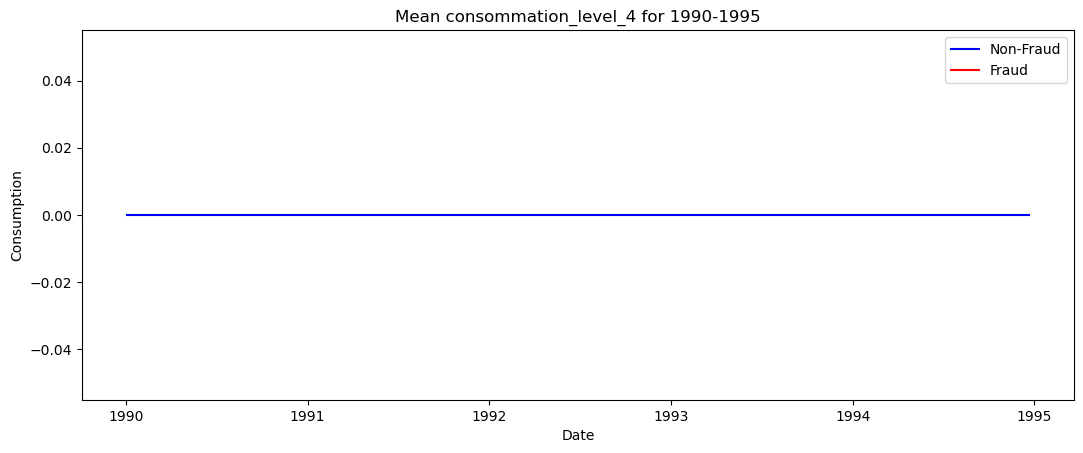

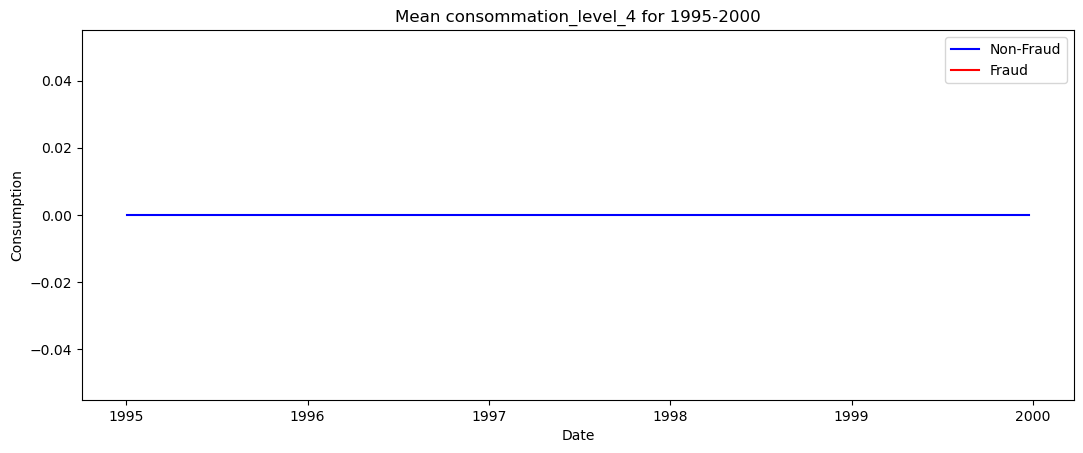

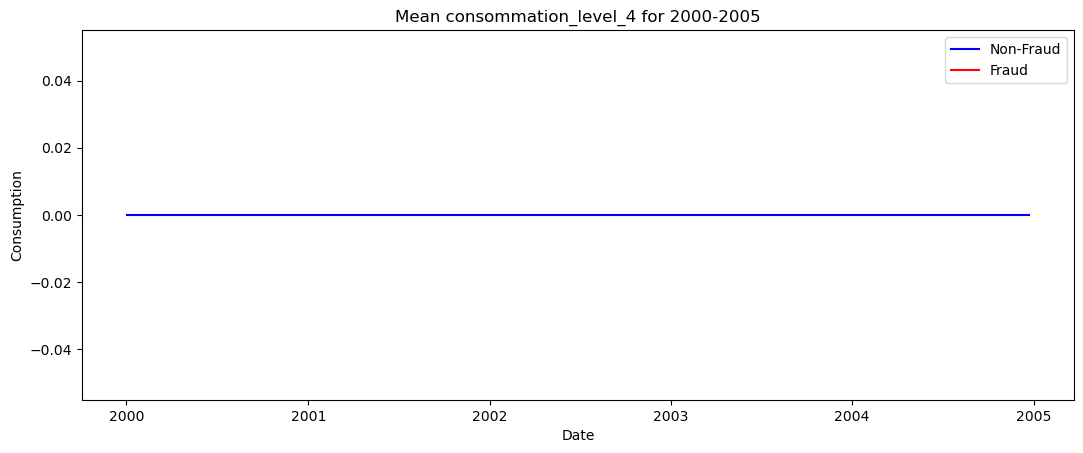

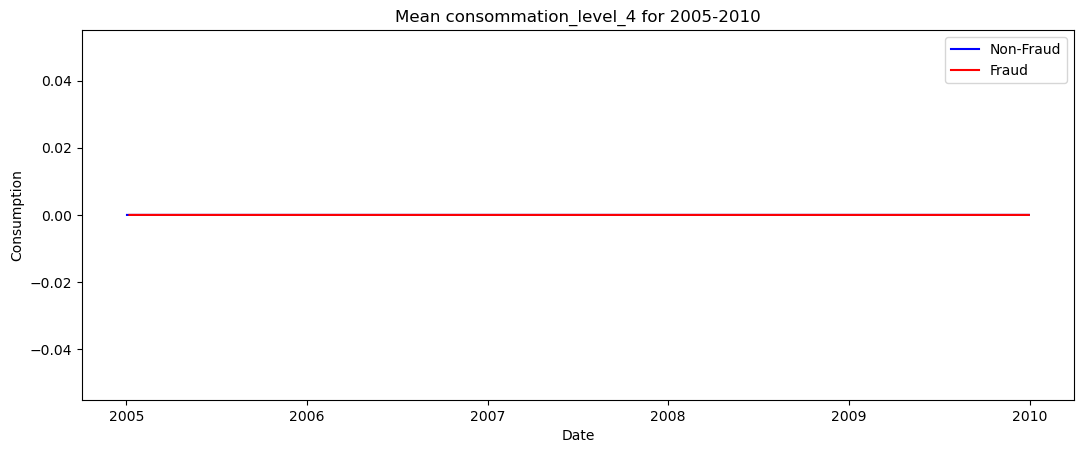

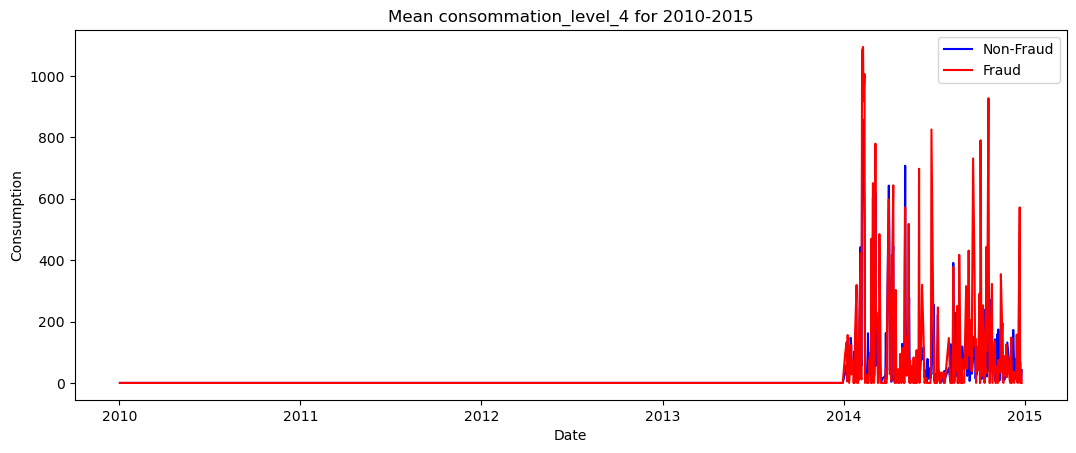

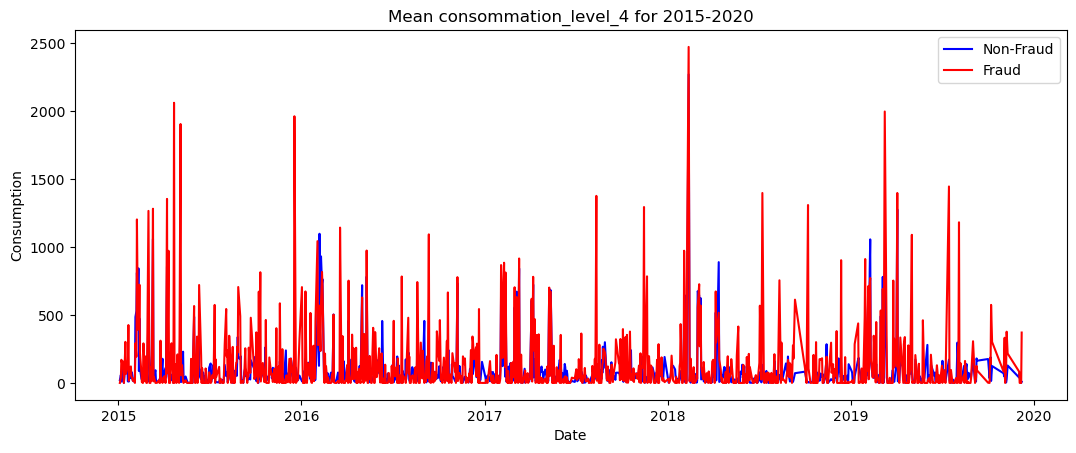

In [6]:
# get separate dataframes for fraudulent and non-fraudulent clients
fraudulent = client[client['target'] == 1]
non_fraudulent = client[client['target'] == 0]
# make a copy of invoice dataframe
df = invoice[:]
# convert date column to pandas date object
df['date'] = pd.to_datetime(df['date'])
# filter invoices by fraud and non-fraud
fraud_df = df[df['id'].isin(fraudulent['id'])]
nonfraud_df = df[df['id'].isin(non_fraudulent['id'])]

# visualize consumption data
cols = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']
mean_vals_fraud = fraud_df[['date'] + cols].groupby('date').mean().reset_index()
mean_vals_nonfraud = nonfraud_df[['date'] + cols].groupby('date').mean().reset_index()
cutoffs = [ pd.to_datetime('2010-01-01'), pd.to_datetime('2020-12-12')]

for c in cols:
    # specify start and end dates for x-axis
    start_date, end_date = pd.to_datetime('1990-01-01'), pd.to_datetime('1995-01-01')
    while end_date <= pd.to_datetime('2020-01-01'):
        # filter by date and plot graphs
        fraud = mean_vals_fraud[(mean_vals_fraud['date'] >= start_date) & (mean_vals_fraud['date'] < end_date)]
        nonfraud = mean_vals_nonfraud[(mean_vals_nonfraud['date'] >= start_date) & (mean_vals_nonfraud['date'] < end_date)]
        plt.figure(figsize=(12.8, 4.8))
        plt.plot(nonfraud['date'], nonfraud[c], label='Non-Fraud', color='blue')
        plt.plot(fraud['date'], fraud[c], label='Fraud', color='red')
        plt.xlabel('Date')
        plt.ylabel('Consumption')
        plt.legend()
        plt.title(f'Mean {c} for {start_date.year}-{end_date.year}')
        plt.show()

        start_date += pd.offsets.DateOffset(years=5)
        end_date += pd.offsets.DateOffset(years=5)

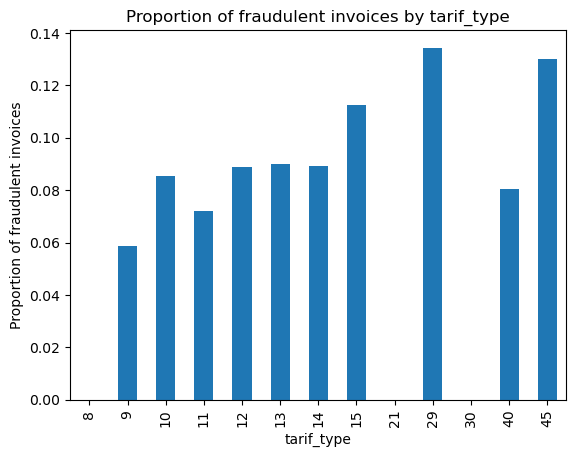

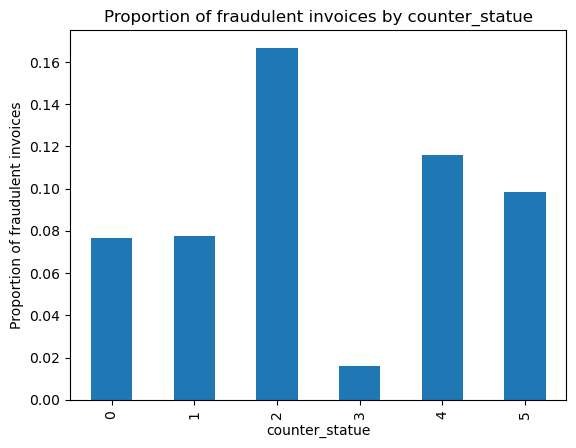

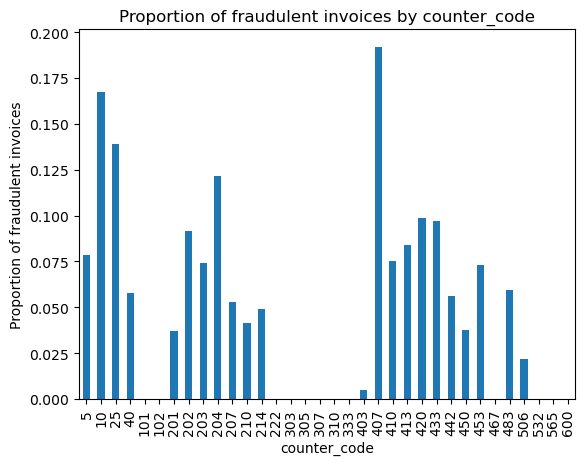

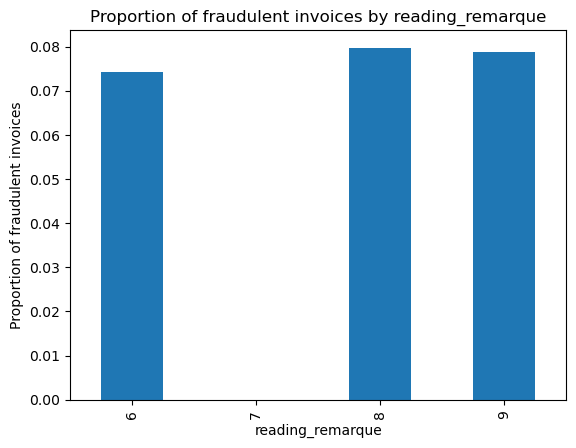

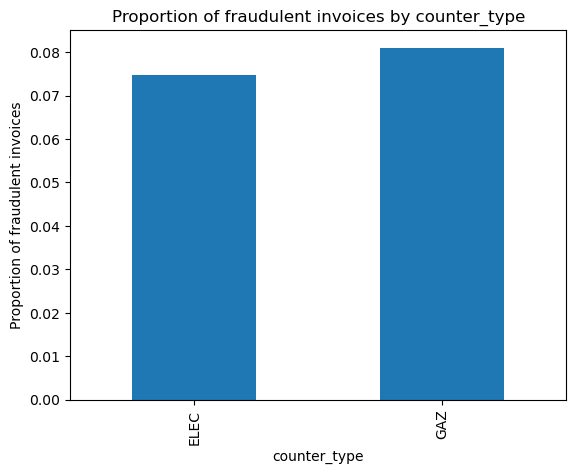

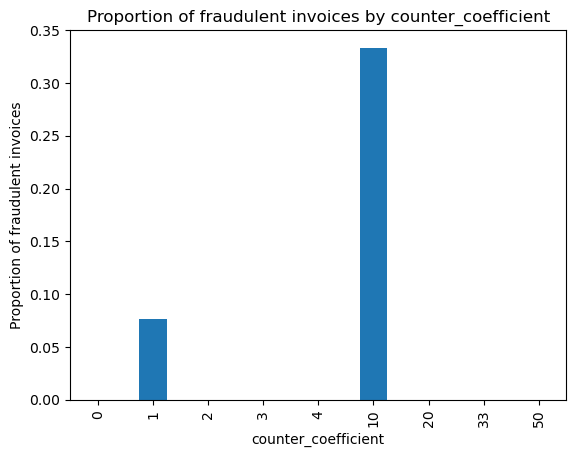

In [7]:
# visualize other invoice columns with respect to proportion of fraudulent clients
# merge invoice and client dataset based on client id
merged_df = pd.merge(client, invoice, on="id")
for col in ['tarif_type', 'counter_statue', 'counter_code',
            'reading_remarque', 'counter_type', 'counter_coefficient']:
            # counter_number, months_number, old_index, new_index, omitted due to too many unique values
    # group rows by current column, get proportion of fraudulent invoices and plot bar chart
    merged_df.groupby(col)["target"].mean().plot(kind="bar")
    plt.xlabel(col)
    plt.ylabel("Proportion of fraudulent invoices")
    plt.title("Proportion of fraudulent invoices by " + col)
    plt.show()

### Invoice Observations
- fraudulent consumption only started after 2005
- fraudulent consumption generally has more and higher peaks than non-fraudulent consumption
- tarif_type 29 had the highest proportion of fraudulent clients, while tarif_type 21 and 30 did not have any fraudulent clients
- counter_statue 2 had the highest proportion of fraudulent clients
- counter_code 407 had the highest proportion of fraudulent clients
- reading_remarque 6, 8 and 9 had around the same proportion of fraudulent clients, while reading_remarque 7 did not have any fraudulent clients
- both categories of counter_type had around the same proportion of fraudulent clients
- counter_coefficient 10 had a large proportion of fraudulent clients, 1 had a small proportion, and the other categories did not have any fraudulent clients

# Dataset

## Feature Engineering

In [6]:
from scipy.stats import mode
# manipulate given features and generate new features
# takes a few minutes to run
def engineer_features(client, invoice):
    # convert date column to client age, assuming today is 2023-01-01
    client['date'] = (pd.to_datetime('2023-01-01') - pd.to_datetime(client['date'], dayfirst=True)).dt.days
    client.rename(columns={'date': 'client_age'}, inplace=True)
    
    # convert categorical variables to category type (should not be integers)
    client['catg'] = client['catg'].astype('category')
    client['dis'] = client['dis'].astype('category')
    client['region'] = client['region'].astype('category')
    
    # convert date column to no. of days since epoch (1970-01-01)
    invoice['date'] = (pd.to_datetime(invoice['date'], dayfirst=True) - pd.to_datetime('1970-01-01')).dt.days
    invoice.rename(columns={'date': 'invoice_date'}, inplace=True)

    # map counter_type to boolean
    invoice['counter_type'] = invoice['counter_type'].replace({"ELEC" : 1, "GAZ" : 0})

    # aggregate features by client id using statistical functions such as min/mean/median/max/std
    # this will group invoices into one set of data per client
    def min_max_range(x): return x.max() - x.min()
    def max_over_mean(x):
        mn = x.mean()
        return x.max() / mn if mn != 0 else 0
    def mode2(x):
        return mode(x)[0]
    def std(x): return np.std(x)
    invoice_new = invoice.groupby(['id']).agg(['min', 'mean', 'max', max_over_mean, std, min_max_range, mode2])
    invoice_new.columns = ['_'.join(col_name).strip() for col_name in invoice_new.columns.values]
    # count number of invoices per client and store in new column 'num_invoices'
    num_invoices = invoice.groupby('id').size().reset_index(name='num_invoices')
    invoice_new = pd.merge(invoice_new, num_invoices, on='id', how='inner')

    # merge client and invoice into one dataframe
    df = pd.merge(client, invoice_new, on='id', how='inner') # 'inner' filters out clients with no invoice info
    # calculate frequency of invoices
    df['invoice_frequency'] = df['num_invoices'] / (df['invoice_date_max'] - df['invoice_date_min'] + 1)
    # drop columns that are not important
    df.drop(['id'], axis=1, inplace=True)

    # finally, generate X and y dataset
    X = df.drop('target', axis=1)
    y = df['target']
    return X, y

# no data leakage as we use only invoices of the same client to aggregate features
X, y = engineer_features(client[:], invoice[:])

## Dataset Splitting

In [7]:
# split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Data Processing: Standardization and Data Cleaning

In [8]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

def preprocess_data(X_train, X_test, y_train, y_test):
    # standardize all columns
    X_train = StandardScaler().set_output(transform='pandas').fit_transform(X_train, y_train)
    X_test = StandardScaler().set_output(transform='pandas').fit_transform(X_test, y_test)

    # tackles limitations of articles
    # balance dataset by performing oversampling and/or undersampling
    # after trial and error, undersampling with ENN algorithm had the best performance
    # Ref: https://imbalanced-learn.org/stable/under_sampling.html
    # Ref2: https://www.kaggle.com/code/residentmario/advanced-under-sampling-and-data-cleaning
    # X_train, y_train = SMOTE(sampling_strategy=0.1).fit_resample(X_train, y_train)
    # clean dataset using RepeatedEditedNearestNeighbours for 10 iterations
    X_train, y_train = RepeatedEditedNearestNeighbours(max_iter=10, n_neighbors=5).fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

# process training and testing datasets, store in different variables
# as we will reuse the unprocessed X_train, X_test, y_train, y_test for k-fold cross validation
X_train_processed, X_test_processed, y_train_processed, y_test_processed = preprocess_data(X_train, X_test, y_train, y_test)
print(np.count_nonzero(y_train_processed == 0) / len(y_train_processed))

0.9277529417809979


## Feature Selection

In [9]:
from sklearn.feature_selection import SelectKBest
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
# Create a SelectKBest selector for feature selection
sel = SelectKBest(k=100)
# Fit the selector
sel.fit(X_train_processed, y_train_processed)

# drop non-selected columns
selected_features = X_train_processed.columns[sel.get_support()]
print(X_train_processed.shape) # initial no. of columns
X_train_processed, X_test_processed = X_train_processed[selected_features], X_test_processed[selected_features]
print(X_train_processed.shape) # no. of columns after dropping
print(X_train_processed.columns) # list of selected columns

(19461, 111)
(19461, 100)
Index(['region', 'client_age', 'dis', 'catg', 'invoice_date_min',
       'invoice_date_mean', 'invoice_date_max', 'invoice_date_max_over_mean',
       'invoice_date_std', 'invoice_date_min_max_range', 'invoice_date_mode2',
       'tarif_type_min', 'tarif_type_mean', 'tarif_type_max',
       'tarif_type_max_over_mean', 'tarif_type_std',
       'tarif_type_min_max_range', 'tarif_type_mode2', 'counter_number_min',
       'counter_number_mean', 'counter_number_max',
       'counter_number_max_over_mean', 'counter_number_std',
       'counter_number_min_max_range', 'counter_number_mode2',
       'counter_statue_min', 'counter_statue_mean', 'counter_statue_max',
       'counter_statue_max_over_mean', 'counter_statue_std',
       'counter_statue_min_max_range', 'counter_statue_mode2',
       'counter_code_min', 'counter_code_mean', 'counter_code_max',
       'counter_code_max_over_mean', 'counter_code_std',
       'counter_code_min_max_range', 'counter_code_mode2',
 

# Methods

## Model Fitting and Evaluation

In [10]:
import timeit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

metric_names = ['Time Taken', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'Avg Precision']
def fit_and_evaluate(model, X_train, X_test, y_train, y_test):
    # train the model
    # can take quite long to run depending on the size of dataset
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)
    elapsed_time = timeit.default_timer() - start_time

    # make predictions
    y_pred = model.predict(X_test)
    # get y_pred probabilities
    y_score = model.predict_proba(X_test)[:, 1]

    # evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # calculate roc_auc
    roc_auc = roc_auc_score(y_test, y_score)
    # calculate auprc
    auprc = average_precision_score(y_test, y_score)
    return (elapsed_time, accuracy, precision, recall, f1, roc_auc, auprc)

def evaluate_model(model):
    return fit_and_evaluate(model, X_train_processed, X_test_processed, y_train_processed, y_test_processed)

## K-Fold Cross Validation

In [11]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold object
# stratified ensures the proportion of fraud and nonfraud is same across all folds
skf = StratifiedKFold(n_splits=3)

# preprocess data for each fold
train_folds = []
# for each fold, preprocess data separately in order to prevent data leakage
for train_index, val_index in skf.split(X_train, y_train):
    # get training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # preprocess datasets
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = preprocess_data(X_train_fold, X_val_fold, y_train_fold, y_val_fold)
    train_folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))

def kfold_validation(model):
    metrics = []
    # train and evaluate models using K-Fold cross-validation
    for X_train_fold, X_val_fold, y_train_fold, y_val_fold in train_folds:
        metrics.append(fit_and_evaluate(model, X_train_fold, X_val_fold, y_train_fold, y_val_fold))
    # calculate mean of each metric
    return tuple(np.mean(metrics, axis=0))

## Model Training

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# initialize classifiers to train
classifier_names = [
    "Logistic Regression",
    "Random Forest",
    "Neural Network",
    'LGBMClassifier',
]

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    MLPClassifier(),
    LGBMClassifier(),
]

# helper function to pretty print metrics
def pprint(classifier_names, classifier_metrics, metric_names):
    max_len = max(len(name) for name in ['Classifier']+classifier_names)
    print(f"{'Classifier':<{max_len}}", *[f"{metric_name:<{len(metric_name)}}" for metric_name in metric_names])
    for metrics, name in zip(classifier_metrics, classifier_names):
        print(f"{name:<{max_len}}", *[f"{str(round(metric, 3)):<{len(metric_names[i])}}" for i,metric in enumerate(metrics)])

In [13]:
# train and cross-validate models
classifier_metrics = []
for classifier, name in zip(classifiers, classifier_names):
    metrics = kfold_validation(classifier)
    classifier_metrics.append(metrics)
    print(name, metrics)

Logistic Regression (0.1197345333348494, 0.9219207901948122, 0.3009860367909813, 0.29231133708745655, 0.2942790194702987, 0.7968373635883929, 0.2301836380837714)
Random Forest (9.076908600002449, 0.9213272292615624, 0.3205653160131868, 0.3407291989381542, 0.3250550897745541, 0.8048977233178727, 0.2729704897861612)
Neural Network (10.40862986666616, 0.8315386456325818, 0.18783948754676896, 0.5213857452663423, 0.26995652829753264, 0.7728667511084545, 0.20820805308538515)
[LightGBM] [Info] Number of positive: 937, number of negative: 11840
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18276
[LightGBM] [Info] Number of data points in the train set: 12777, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073335 -> initscore=-2.536556
[LightGBM] [Info] Start training from score -2.536556
[LightGBM] [Info] Number of p

In [14]:
pprint(classifier_names, classifier_metrics, metric_names)

Classifier          Time Taken Accuracy Precision Recall F1 Score ROC-AUC Avg Precision
Logistic Regression 0.12       0.922    0.301     0.292  0.294    0.797   0.23         
Random Forest       9.077      0.921    0.321     0.341  0.325    0.805   0.273        
Neural Network      10.409     0.832    0.188     0.521  0.27     0.773   0.208        
LGBMClassifier      0.404      0.925    0.337     0.334  0.331    0.822   0.276        


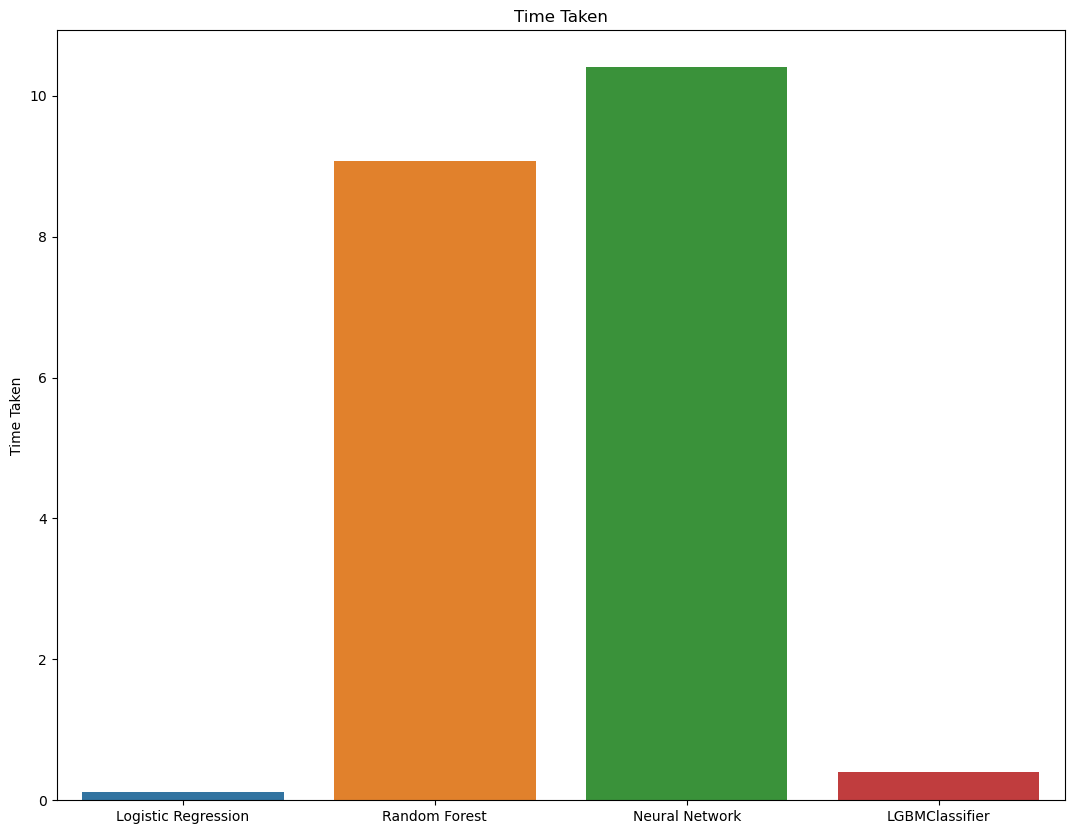

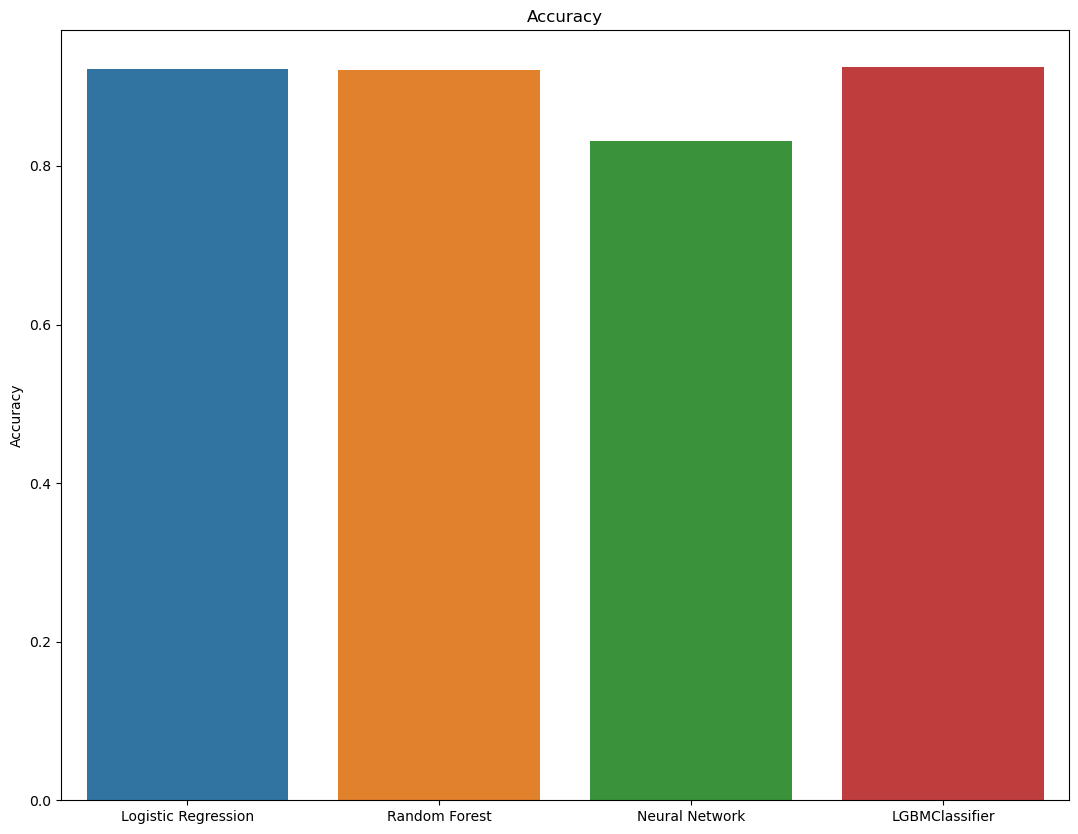

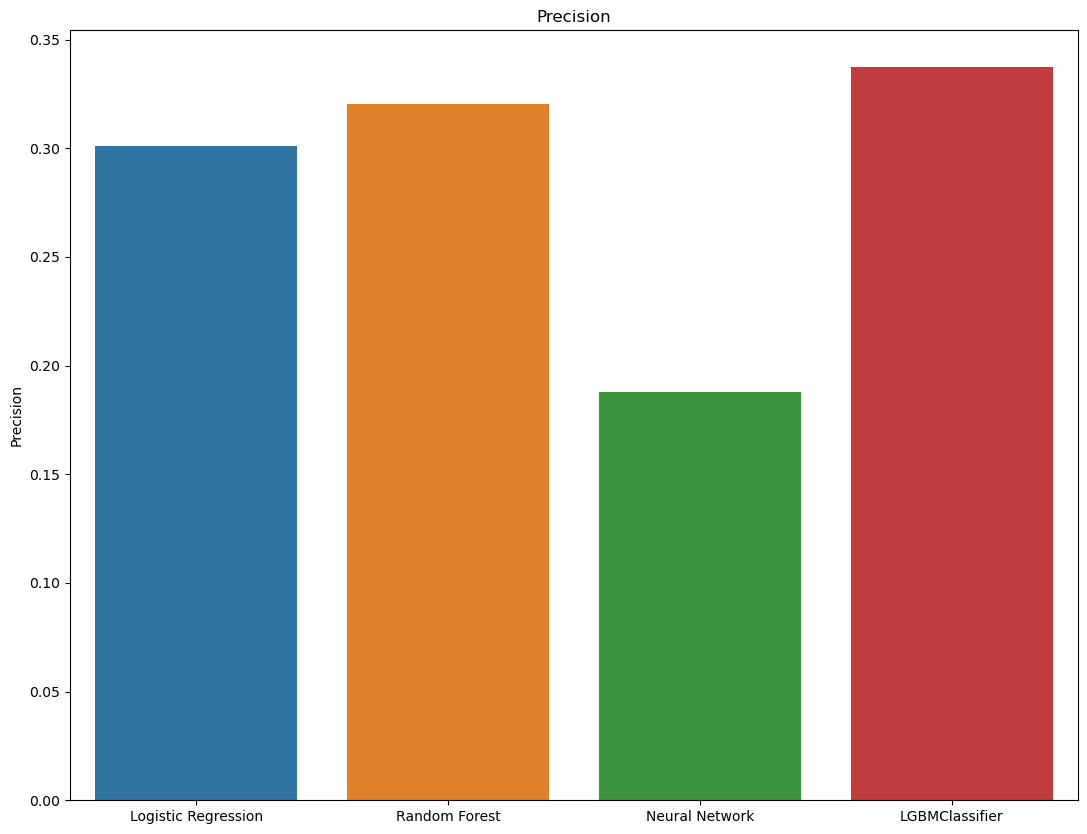

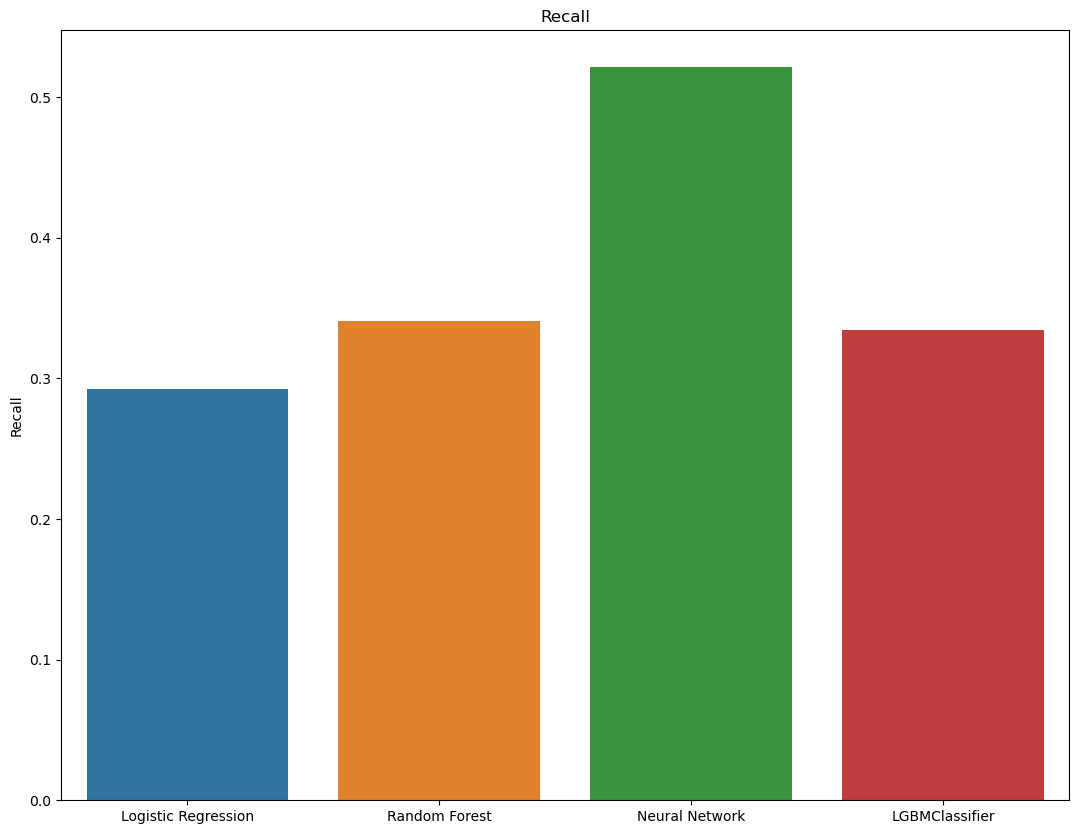

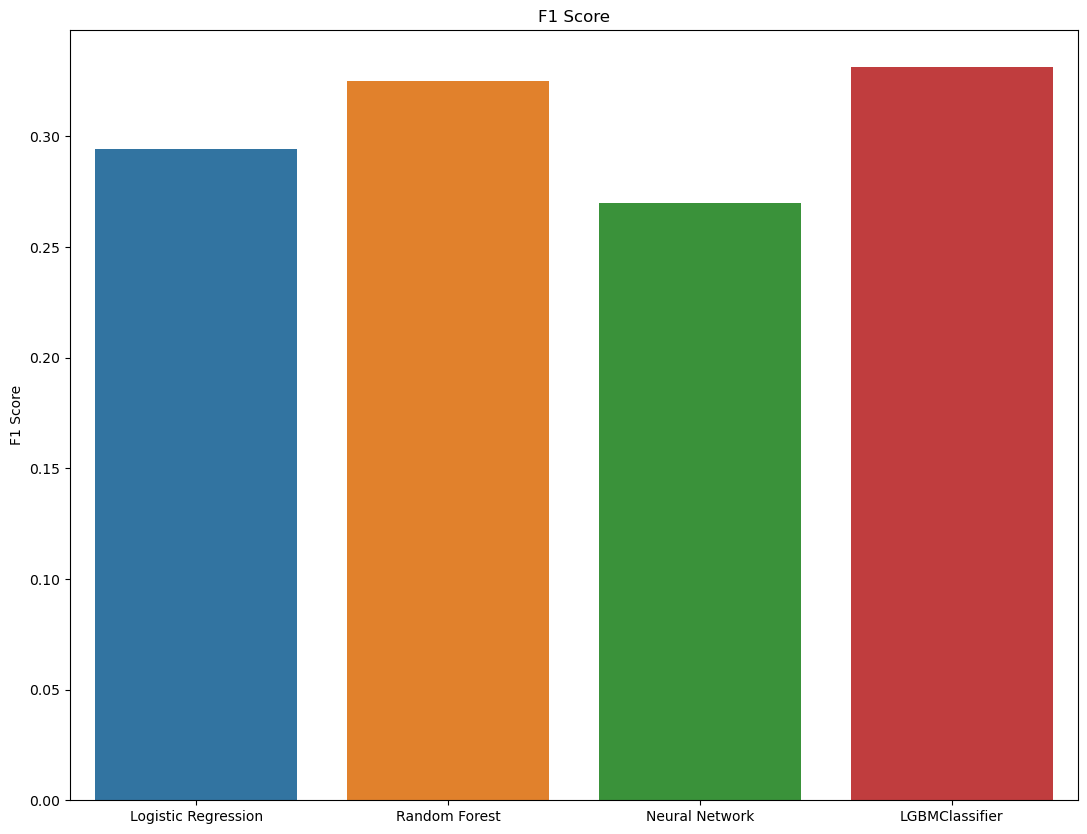

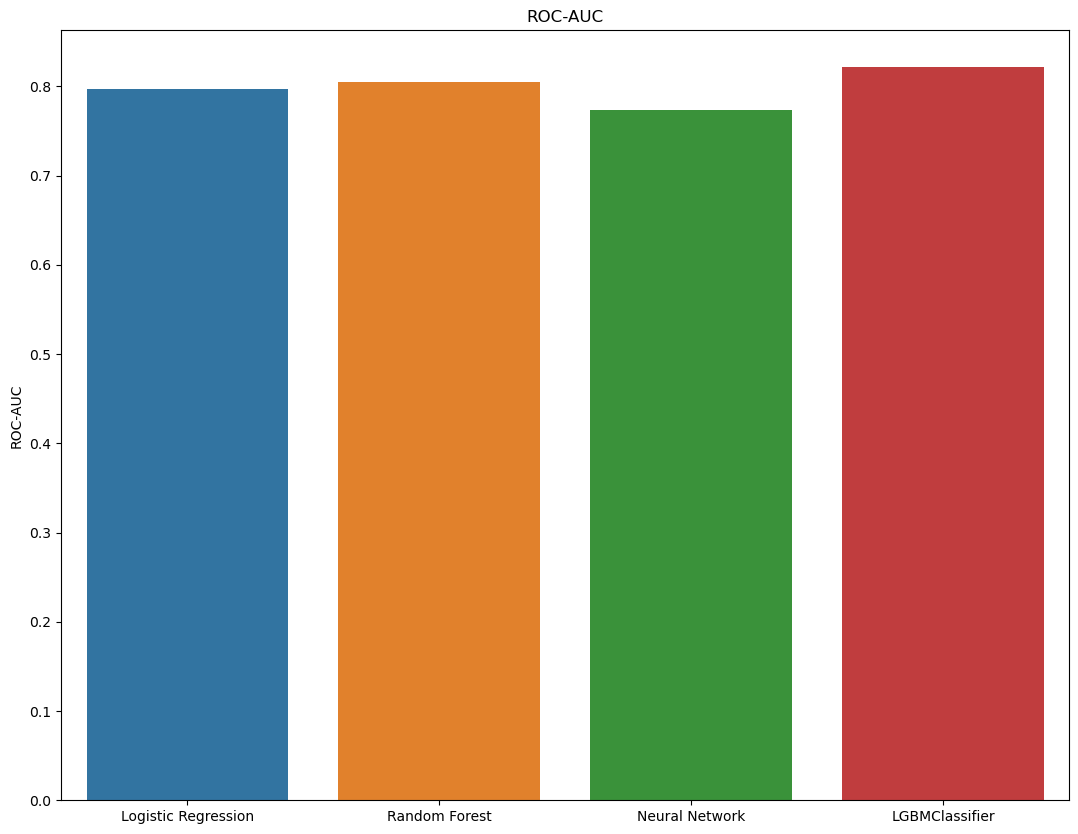

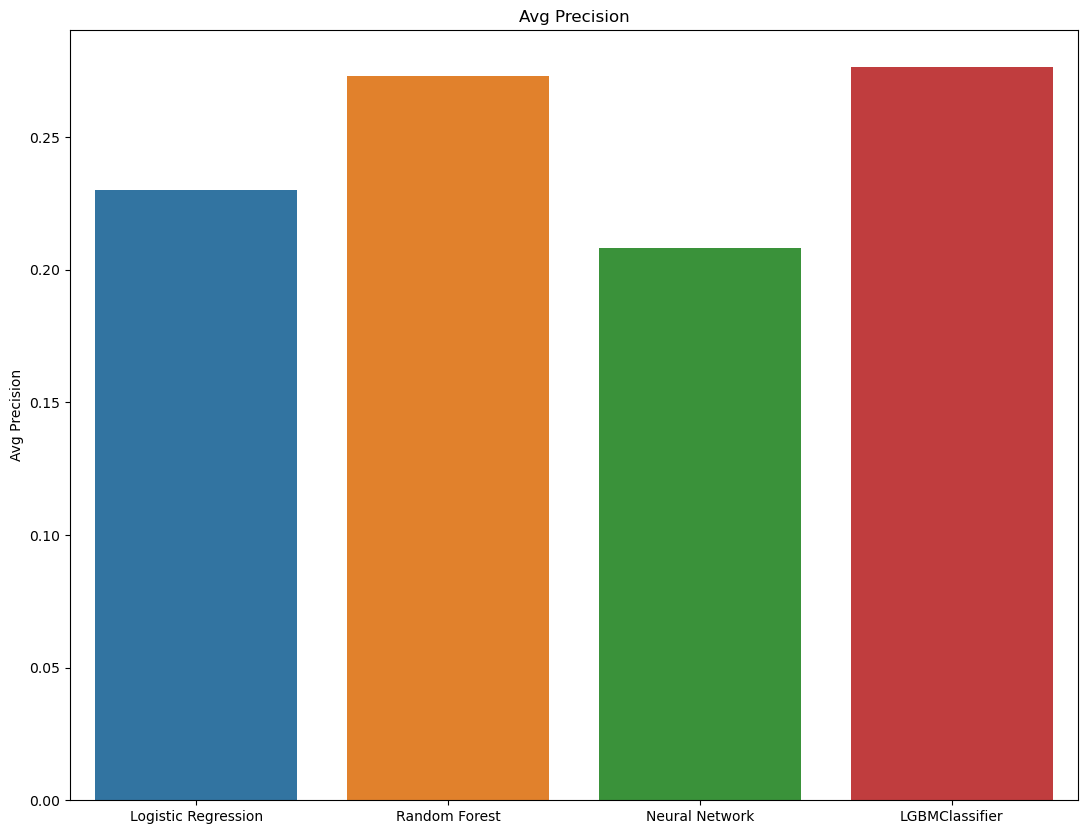

In [15]:
# plot the reuslts with seaborn
metrics_df = pd.DataFrame(dict(zip(classifier_names, classifier_metrics)), index=metric_names)

# Create subplots for each metric
for metric_name in metric_names:
    plt.figure(figsize=(13, 10))
    sns.barplot(x=metrics_df.columns, y=metrics_df.loc[metric_name])
    plt.title(metric_name)
    plt.show()

## Model Tuning

In [19]:
import optuna

# helper function to run optuna
def optuna_run(objective):
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=100, n_jobs=8) # increase n_trials for better tuning at the cost of cpu time
    return study.best_params

# list to store all tuned models for k-fold cross validation
tuned_model_names = []
tuned_models = []

In [20]:
# tune LogisticRegression
def objective(trial):
    # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    params = {
        'penalty': trial.suggest_categorical('penalty', [None, 'l2']),
        'C': trial.suggest_loguniform('C', 1e-5, 100),
    }
    model = LogisticRegression(**params)
    # maximize f1 score
    return kfold_validation(model)[-3]

best_params = optuna_run(objective)
tuned_model_names.append("LogisticRegression_tuned")
LogisticRegression_tuned = LogisticRegression(**best_params)
tuned_models.append(LogisticRegression_tuned)
LogisticRegression_tuned

[I 2023-10-28 00:15:59,315] A new study created in memory with name: no-name-1839fafd-f76c-4f8d-bc69-d282316e3adc
[I 2023-10-28 00:16:04,199] Trial 7 finished with value: 0.2955092880116211 and parameters: {'penalty': None, 'C': 0.0025247846626596424}. Best is trial 7 with value: 0.2955092880116211.
[I 2023-10-28 00:16:04,209] Trial 1 finished with value: 0.29474980665428363 and parameters: {'penalty': 'l2', 'C': 0.4628556220011144}. Best is trial 7 with value: 0.2955092880116211.
[I 2023-10-28 00:16:04,230] Trial 4 finished with value: 0.29474482855855977 and parameters: {'penalty': 'l2', 'C': 1.8396350603587028}. Best is trial 7 with value: 0.2955092880116211.
[I 2023-10-28 00:16:04,246] Trial 3 finished with value: 0.2955092880116211 and parameters: {'penalty': None, 'C': 2.4331454881957735e-05}. Best is trial 7 with value: 0.2955092880116211.
[I 2023-10-28 00:16:04,260] Trial 2 finished with value: 0.2960260788531086 and parameters: {'penalty': 'l2', 'C': 55.87359705940657}. Best i

LogisticRegression(C=7.545389253953492)

In [21]:
# tune RandomForestClassifier
def objective(trial):
    # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 90, 150), # Number of trees in the forest
        'max_depth': trial.suggest_int('max_depth', 1, 100), # Maximum depth of the trees
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 64), # Minimum samples required to be at a leaf node
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64), # Minimum samples required to split an internal node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]) # Number of features to consider for the best split
    }
    model = RandomForestClassifier(**params)
    # maximize f1 score
    return kfold_validation(model)[-3]

best_params = optuna_run(objective)
tuned_model_names.append("RFC_tuned")
RFC_tuned = RandomForestClassifier(**best_params)
tuned_models.append(RFC_tuned)
RFC_tuned

[I 2023-10-28 00:16:51,344] A new study created in memory with name: no-name-938376d9-9f2b-4769-b5a8-635fe8d36025
[I 2023-10-28 00:16:55,805] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 102, 'max_depth': 2, 'min_samples_leaf': 45, 'min_samples_split': 17, 'max_features': 'log2'}. Best is trial 5 with value: 0.0.
[I 2023-10-28 00:17:04,002] Trial 28 finished with value: 0.2998378898129234 and parameters: {'n_estimators': 140, 'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 29, 'max_features': None}. Best is trial 30 with value: 0.32092312373462534.
[I 2023-10-28 00:17:06,948] Trial 4 finished with value: 0.21637219328192403 and parameters: {'n_estimators': 111, 'max_depth': 79, 'min_samples_leaf': 55, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 4 with value: 0.21637219328192403.
[I 2023-10-28 00:17:07,069] Trial 2 finished with value: 0.2178159589084612 and parameters: {'n_estimators': 110, 'max_depth': 94, 'min_samples_leaf': 51, '

RandomForestClassifier(max_depth=19, min_samples_leaf=3, n_estimators=118)

In [22]:
# tune MLPClassifier
def objective(trial):
    # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))
    params = {
        'hidden_layer_sizes' : tuple(layers),
        'activation' : trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"]),
        'alpha': trial.suggest_loguniform("alpha", 1e-6, 1e-2),
    }
    model = MLPClassifier(**params)
    # maximize f1 score
    return kfold_validation(model)[-3]

best_params = optuna_run(objective)
layers = []
for i in range(best_params['n_layers']):
    key = f'n_units_{i}'
    layers.append(best_params[key])
    del best_params[key]
del best_params['n_layers']
best_params['hidden_layer_sizes'] = tuple(layers)
tuned_model_names.append("MLP_tuned")
MLP_tuned = MLPClassifier(**best_params)
tuned_models.append(MLP_tuned)
MLP_tuned

[I 2023-10-28 00:36:47,504] A new study created in memory with name: no-name-32f7a6e6-3f3b-4e8c-a25b-e6e52914aa39
[I 2023-10-28 00:37:16,199] Trial 2 finished with value: 0.2953733713134837 and parameters: {'n_layers': 1, 'n_units_0': 96, 'activation': 'identity', 'alpha': 1.7318087433884577e-06}. Best is trial 2 with value: 0.2953733713134837.
[I 2023-10-28 00:37:42,009] Trial 8 finished with value: 0.297265753008453 and parameters: {'n_layers': 3, 'n_units_0': 1, 'n_units_1': 4, 'n_units_2': 26, 'activation': 'identity', 'alpha': 1.6636507592130533e-05}. Best is trial 8 with value: 0.297265753008453.
[I 2023-10-28 00:38:06,364] Trial 1 finished with value: 0.2943856898233759 and parameters: {'n_layers': 4, 'n_units_0': 90, 'n_units_1': 17, 'n_units_2': 48, 'n_units_3': 43, 'activation': 'identity', 'alpha': 3.729072840492853e-06}. Best is trial 8 with value: 0.297265753008453.
[I 2023-10-28 00:39:08,249] Trial 3 finished with value: 0.2855142599045038 and parameters: {'n_layers': 2, 

MLPClassifier(activation='logistic', alpha=0.009143883516738244,
              hidden_layer_sizes=(23,))

In [41]:
# tune LGBMClassifier
def objective(trial):
    # Ref: https://lightgbm.readthedocs.io/en/latest/Parameters.html
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'max_depth': trial.suggest_int('max_depth', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 128),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
        'verbosity': -1,
    }
    model = LGBMClassifier(**params)
    return kfold_validation(model)[-3] # maximize f1 score

best_params = optuna_run(objective)
tuned_model_names.append("LGBM_tuned")
LGBM_tuned = LGBMClassifier(**best_params)
tuned_models.append(LGBM_tuned)
LGBM_tuned

[I 2023-10-28 01:28:12,819] A new study created in memory with name: no-name-f350ecb1-e0ec-4c64-a926-1bc4c4183b8d
[I 2023-10-28 01:28:28,208] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 134, 'num_leaves': 57, 'max_depth': 37, 'min_samples_leaf': 86, 'learning_rate': 0.0017574745410255607, 'min_split_gain': 0.001713015462389392}. Best is trial 3 with value: 0.0.
[I 2023-10-28 01:28:31,155] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 281, 'num_leaves': 80, 'max_depth': 2, 'min_samples_leaf': 119, 'learning_rate': 0.0015153077105380113, 'min_split_gain': 0.01907767638121135}. Best is trial 3 with value: 0.0.
[I 2023-10-28 01:28:31,833] Trial 6 finished with value: 0.3500849669481699 and parameters: {'n_estimators': 576, 'num_leaves': 13, 'max_depth': 41, 'min_samples_leaf': 82, 'learning_rate': 0.03104754956333798, 'min_split_gain': 0.0035023222210776484}. Best is trial 6 with value: 0.3500849669481699.
[I 2023-10-28 01:28:42,581] Trial 7 finish

LGBMClassifier(learning_rate=0.03104754956333798, max_depth=41,
               min_samples_leaf=82, min_split_gain=0.0035023222210776484,
               n_estimators=576, num_leaves=13)

In [60]:
# uncomment these lines if did not run the tuning code blocks
# tuned_models = [LogisticRegression(C=7.545389253953492),
#                 RandomForestClassifier(max_depth=19, min_samples_leaf=3, n_estimators=118),
#                 MLPClassifier(activation='logistic', alpha=0.009143883516738244, hidden_layer_sizes=(23,)),
#                 LGBMClassifier(learning_rate=0.03104754956333798, max_depth=41, min_samples_leaf=82,
#                                min_split_gain=0.0035023222210776484, n_estimators=576, num_leaves=13)]
# tuned_model_names = ['LogisticRegression_tuned', 'RFC_tuned', 'MLP_tuned', 'LGBM_tuned']

# train and validate tuned models
tuned_metrics = [kfold_validation(model) for model in tuned_models]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 937, number of negative: 11840
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18235
[LightGBM] [Info] Number of data points in the train set: 12777, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073335 -> initscore=-2.536556
[LightGBM] [Info] Start training from score -2.536556
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set with min

In [61]:
# print k-fold cross validation results and compare to baselines (untuned models)
pprint(classifier_names + tuned_model_names, classifier_metrics + tuned_metrics, metric_names)

Classifier               Time Taken Accuracy Precision Recall F1 Score ROC-AUC Avg Precision
Logistic Regression      0.12       0.922    0.301     0.292  0.294    0.797   0.23         
Random Forest            9.077      0.921    0.321     0.341  0.325    0.805   0.273        
Neural Network           10.409     0.832    0.188     0.521  0.27     0.773   0.208        
LGBMClassifier           0.404      0.925    0.337     0.334  0.331    0.822   0.276        
LogisticRegression_tuned 0.179      0.921    0.3       0.3    0.297    0.795   0.23         
RFC_tuned                9.469      0.927    0.349     0.314  0.324    0.818   0.285        
MLP_tuned                7.376      0.903    0.262     0.406  0.318    0.809   0.256        
LGBM_tuned               0.951      0.927    0.355     0.354  0.35     0.829   0.285        


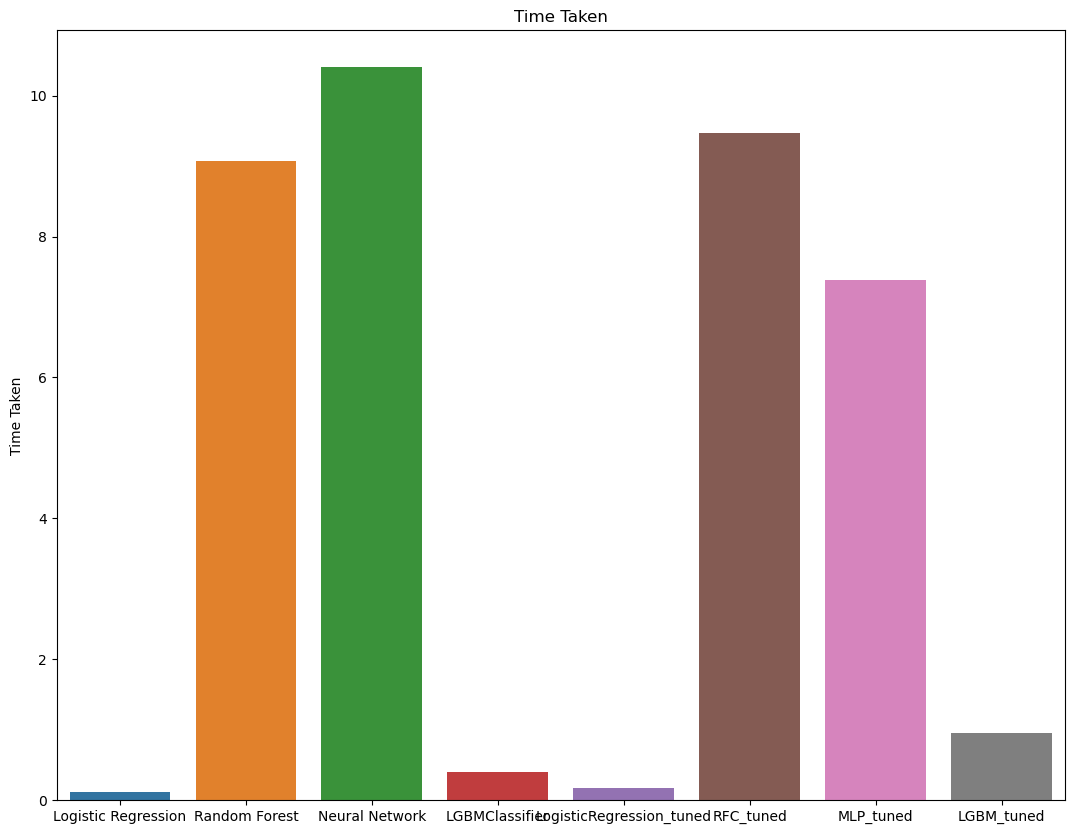

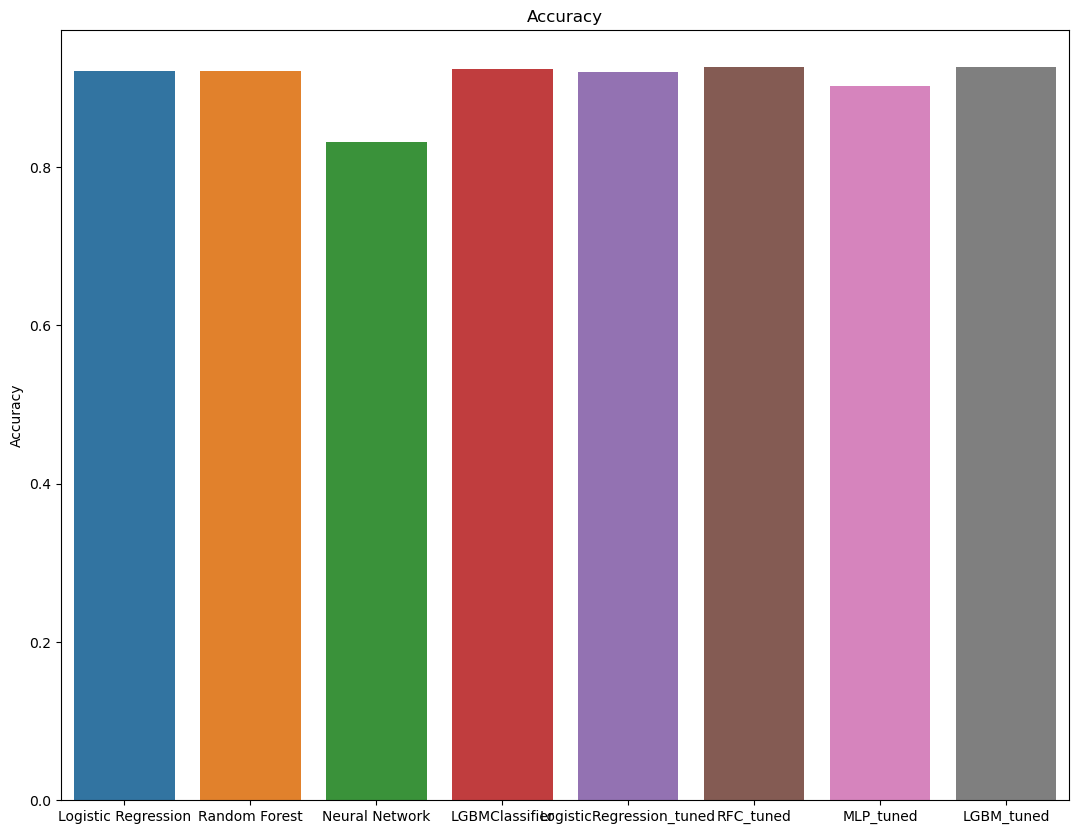

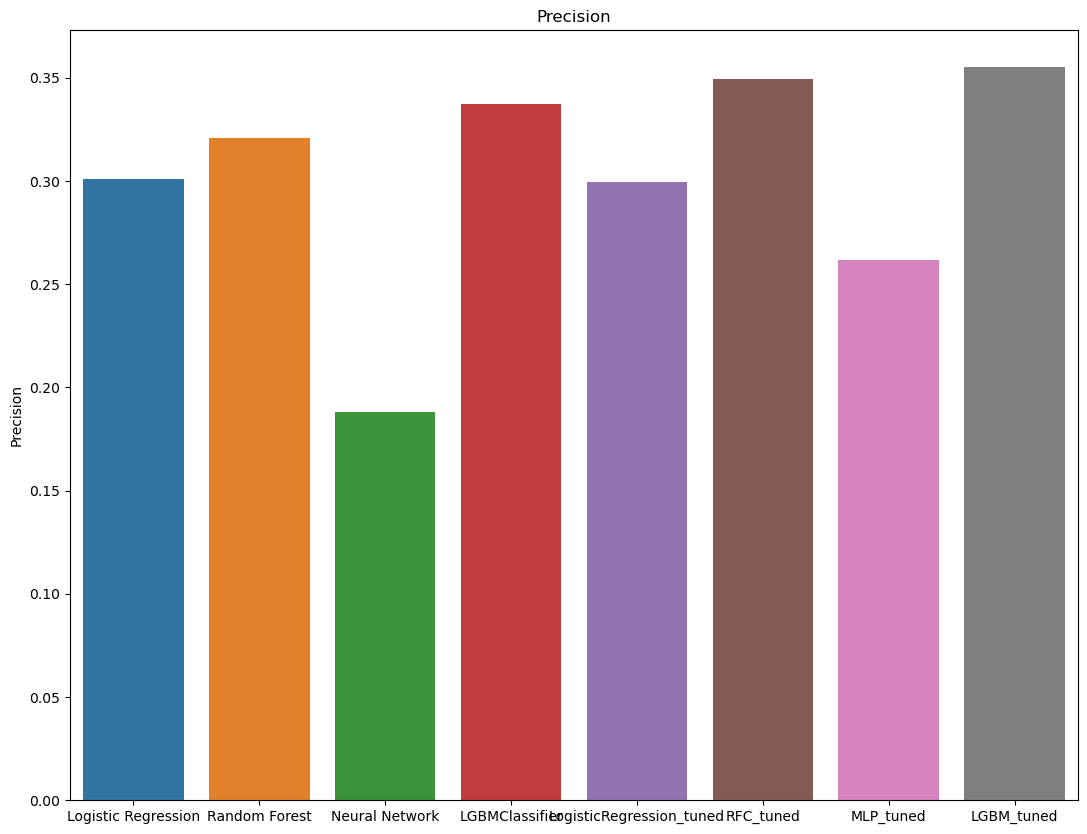

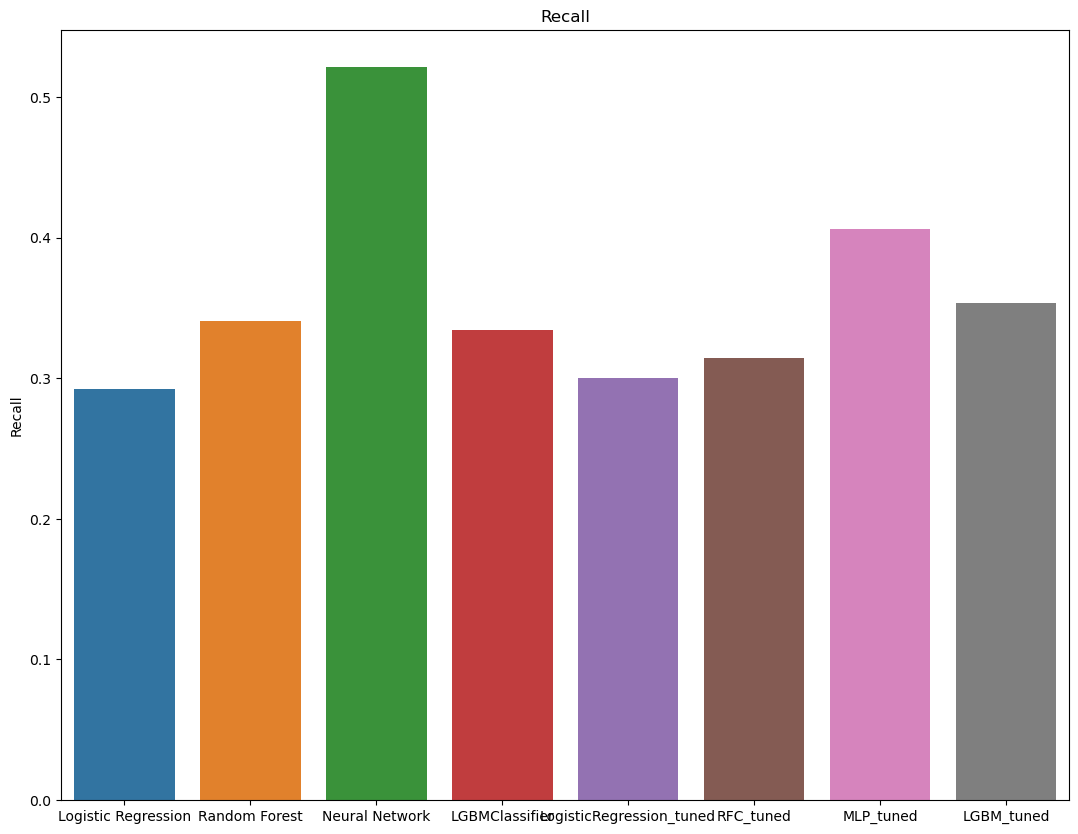

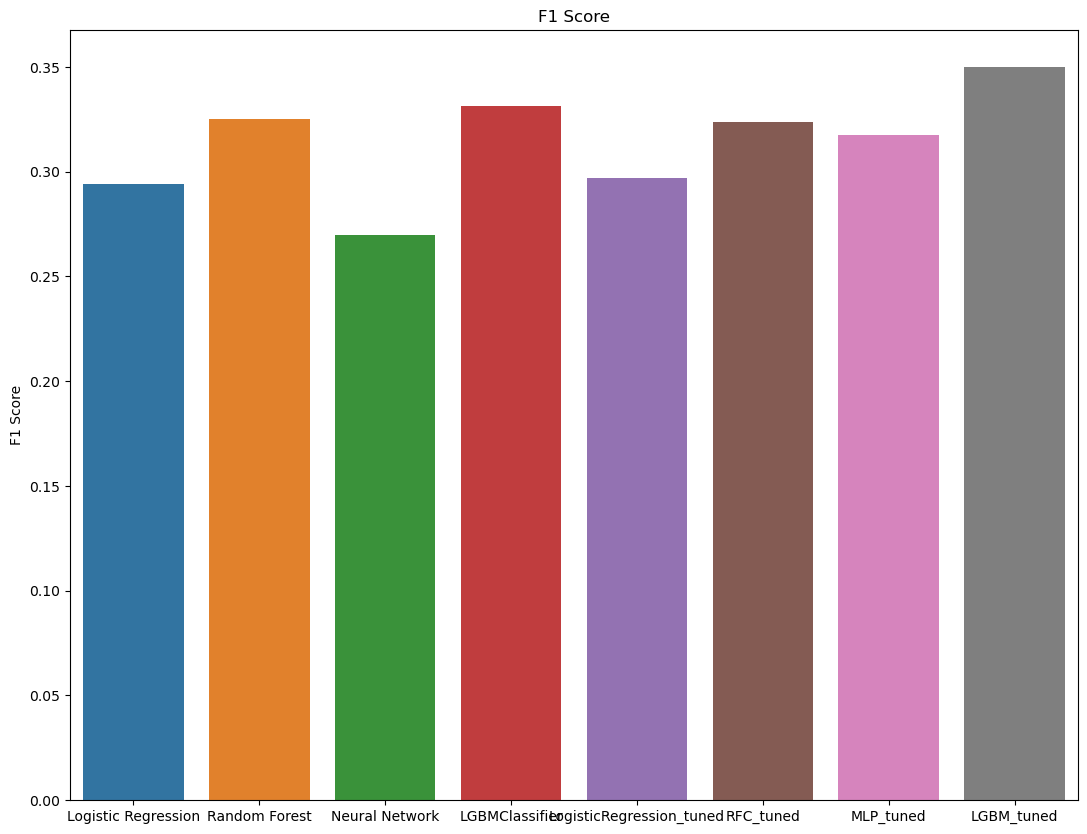

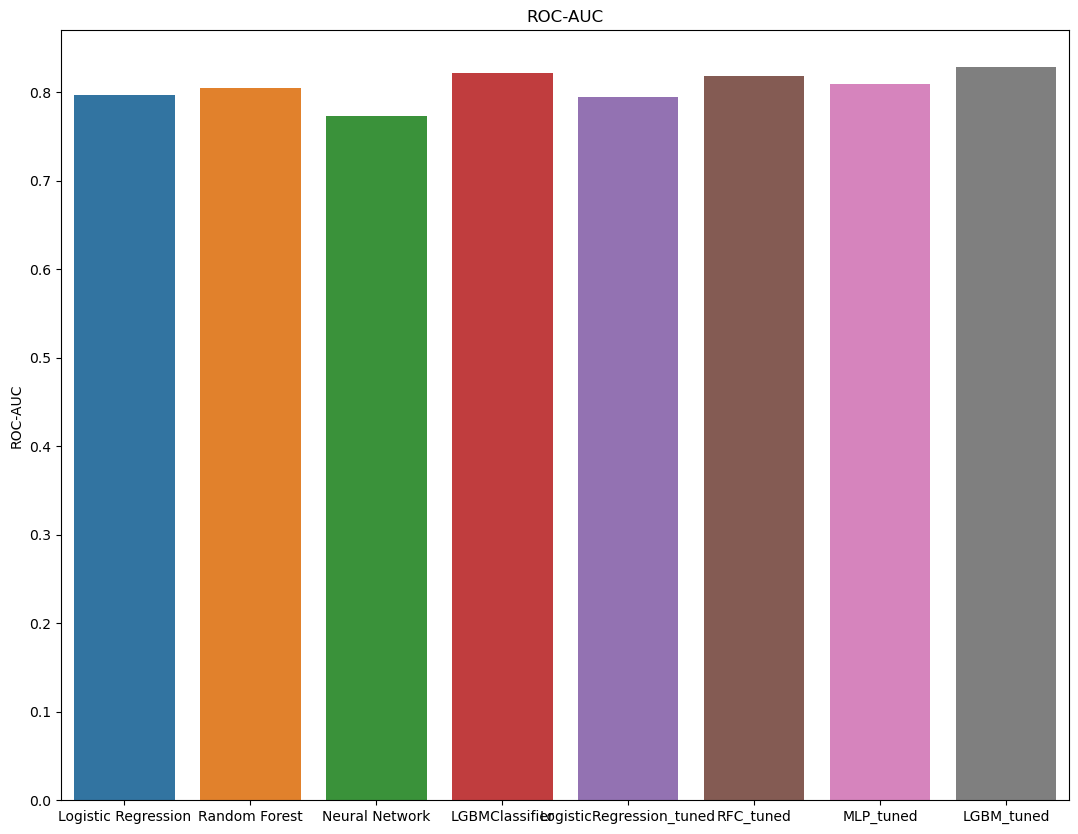

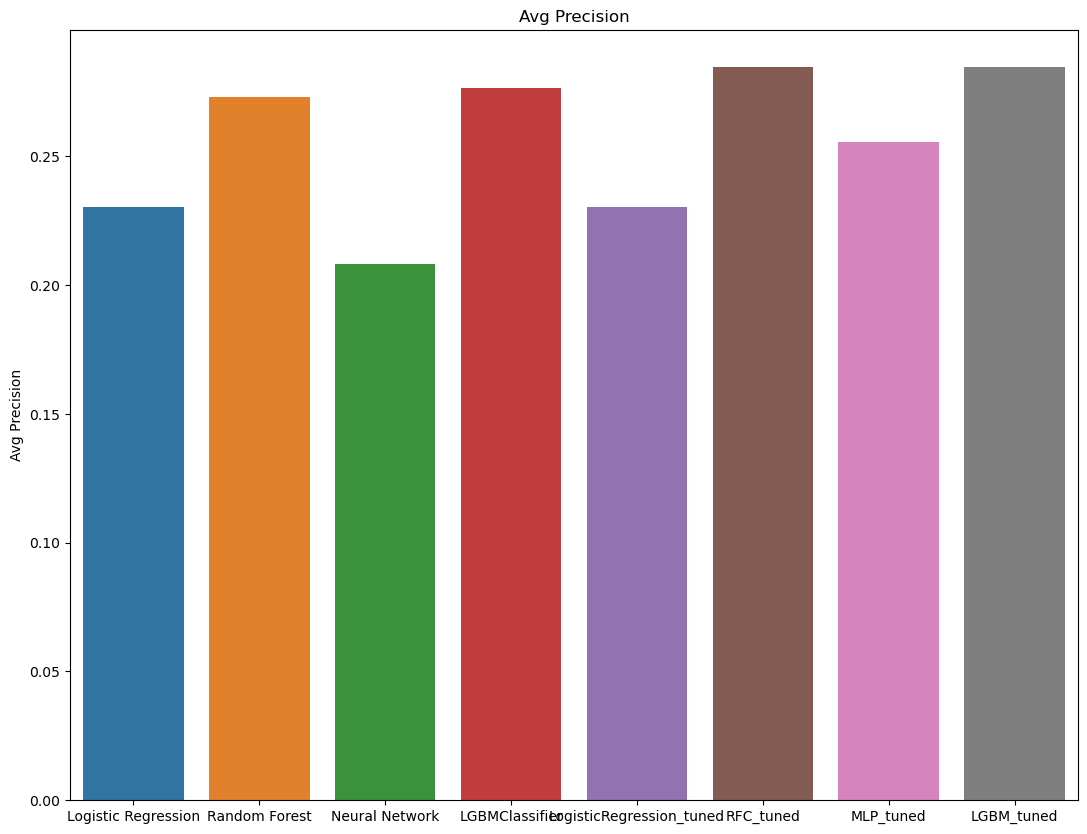

In [67]:
# plot the results with seaborn
metrics_df = pd.DataFrame(dict(zip(classifier_names + tuned_model_names, classifier_metrics + tuned_metrics)), index=metric_names)

# Create subplots for each metric
for metric_name in metric_names:
    plt.figure(figsize=(13, 10))
    sns.barplot(x=metrics_df.columns, y=metrics_df.loc[metric_name])
    plt.title(metric_name)
    plt.show()

## Model Evaluation & Results

In [62]:
# choose best performing model and train it
model = LGBM_tuned
model_name = 'LGBM_tuned'
model.fit(X_train_processed, y_train_processed)
evaluation = evaluate_model(LGBM_tuned)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 1406, number of negative: 18055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17694
[LightGBM] [Info] Number of data points in the train set: 19461, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072247 -> initscore=-2.552674
[LightGBM] [Info] Start training from score -2.552674
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set with min

In [63]:
pprint([model_name], [evaluation], metric_names)

Classifier Time Taken Accuracy Precision Recall F1 Score ROC-AUC Avg Precision
LGBM_tuned 1.127      0.92     0.311     0.362  0.335    0.836   0.294        


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82


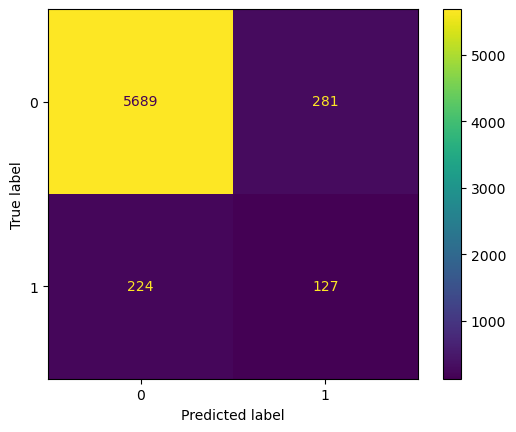

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute confusion matrix
y_pred = model.predict(X_test_processed)
ConfusionMatrixDisplay(confusion_matrix(y_test_processed, y_pred)).plot()
pass

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_prob = model.predict_proba(X_test_processed)[:, 1]

# helper function to plot ROC curve
def plot_ROC(model):
    fpr, tpr, threshold = roc_curve(y_test_processed, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.title(f'ROC curve of tuned {model.__class__.__name__}')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# helper function to plot PR curve
def plot_PR(model):
    precision, recall, threshold = precision_recall_curve(y_test_processed, y_prob)
    auprc = auc(recall, precision)

    plt.title(f'PR curve of tuned {model.__class__.__name__}')
    plt.plot(recall, precision, 'b', label=f'AUPRC = {auprc:.2f}')
    plt.legend(loc='lower left')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=82. Current value: min_data_in_leaf=82


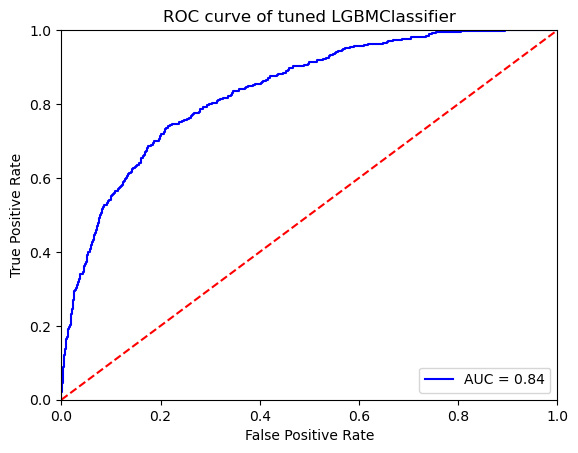

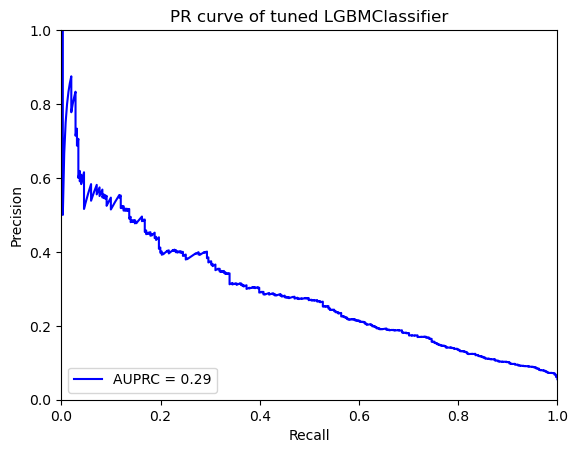

In [66]:
plot_ROC(model)
plot_PR(model)

## Comparison with previously done work

We compare our model's performance with the [reference model](https://www.kaggle.com/code/imgremlin/4th-place-in-fraud-detection-from-zindi/notebook). Our model was trained on a much smaller subset of data (~30000 clients) compared to the reference model which was trained on over 130000 clients.

The reference model had an F1 score of 0.27, with and ROC-AUC of 0.88.

Our model has an F1 score of 0.335 and ROC-AUC of 0.84. Although the ROC-AUC is slightly worse, the improved F1 score shows that our model has a better balance between the precision and recall. Comparatively, these results are good, given the large difference in the number of training samples between the reference model and our model.